# 1. Business Understanding
### __Stroke Prediction__
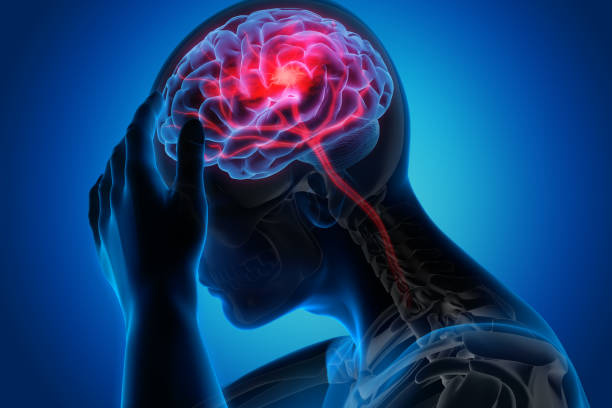

This data science project aims to predict the likelihood of a patient experiencing a stroke based on various input parameters such as gender, age, presence of diseases, and smoking status. The dataset provides relevant information about each patient, enabling the development of a predictive model.
Dataset Information
The dataset used in this project contains information necessary to predict the occurrence of a stroke. Each row in the dataset represents a patient, and the dataset includes the following attributes:
1.	__id__: Unique identifier
2.	__gender__: "Male", "Female", or "Other"
3.	__age__: Age of the patient
4.	__hypertension__: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5.	__heart_disease__: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6.	__ever_married__: "No" or "Yes"
7.	__work_type__: "Children", "Govt_job", "Never_worked", "Private", or "Self-employed"
8.	__Residence_type__: "Rural" or "Urban"
9.	__avg_glucose_level__: Average glucose level in the blood
10.	__bmi__: Body mass index
11.	__smoking_status__: "Formerly smoked", "Never smoked", "Smokes", or "Unknown"
12.	__stroke__: 1 if the patient had a stroke, 0 if not

### __Context__
According to the World Health Organization (WHO), stroke is the second leading cause of death worldwide, responsible for approximately 11% of total deaths. This project aims to leverage machine learning techniques to build a predictive model that can identify individuals at risk of stroke based on their demographic and health-related features. By detecting high-risk individuals early, appropriate preventive measures can be taken to reduce the incidence and impact of stroke.
To enhance the accuracy of the stroke prediction model, the dataset will be analyzed and processed using various data science methodologies and algorithms.

# 2. Data Understanding

### Importing Libraries

In [1]:
from numpy import mean, std, unique, nan, array
from pandas import read_csv, concat, DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer, KBinsDiscretizer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from pickle import dump, load
import tkinter as tk
from tkinter import ttk, messagebox
import ctypes
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

### Loading Dataset

In [2]:
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
df.index = range(1, df.shape[0] + 1)
print(f"Shape: {df.shape[0]} Samples x ({df.shape[1] - 1} Features + 1 Target)")
df.describe()

Shape: 5110 Samples x (11 Features + 1 Target)


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Removing Ineffective Column

In [3]:
df.drop("id", axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
3,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Analyzing Categorical Features

In [4]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

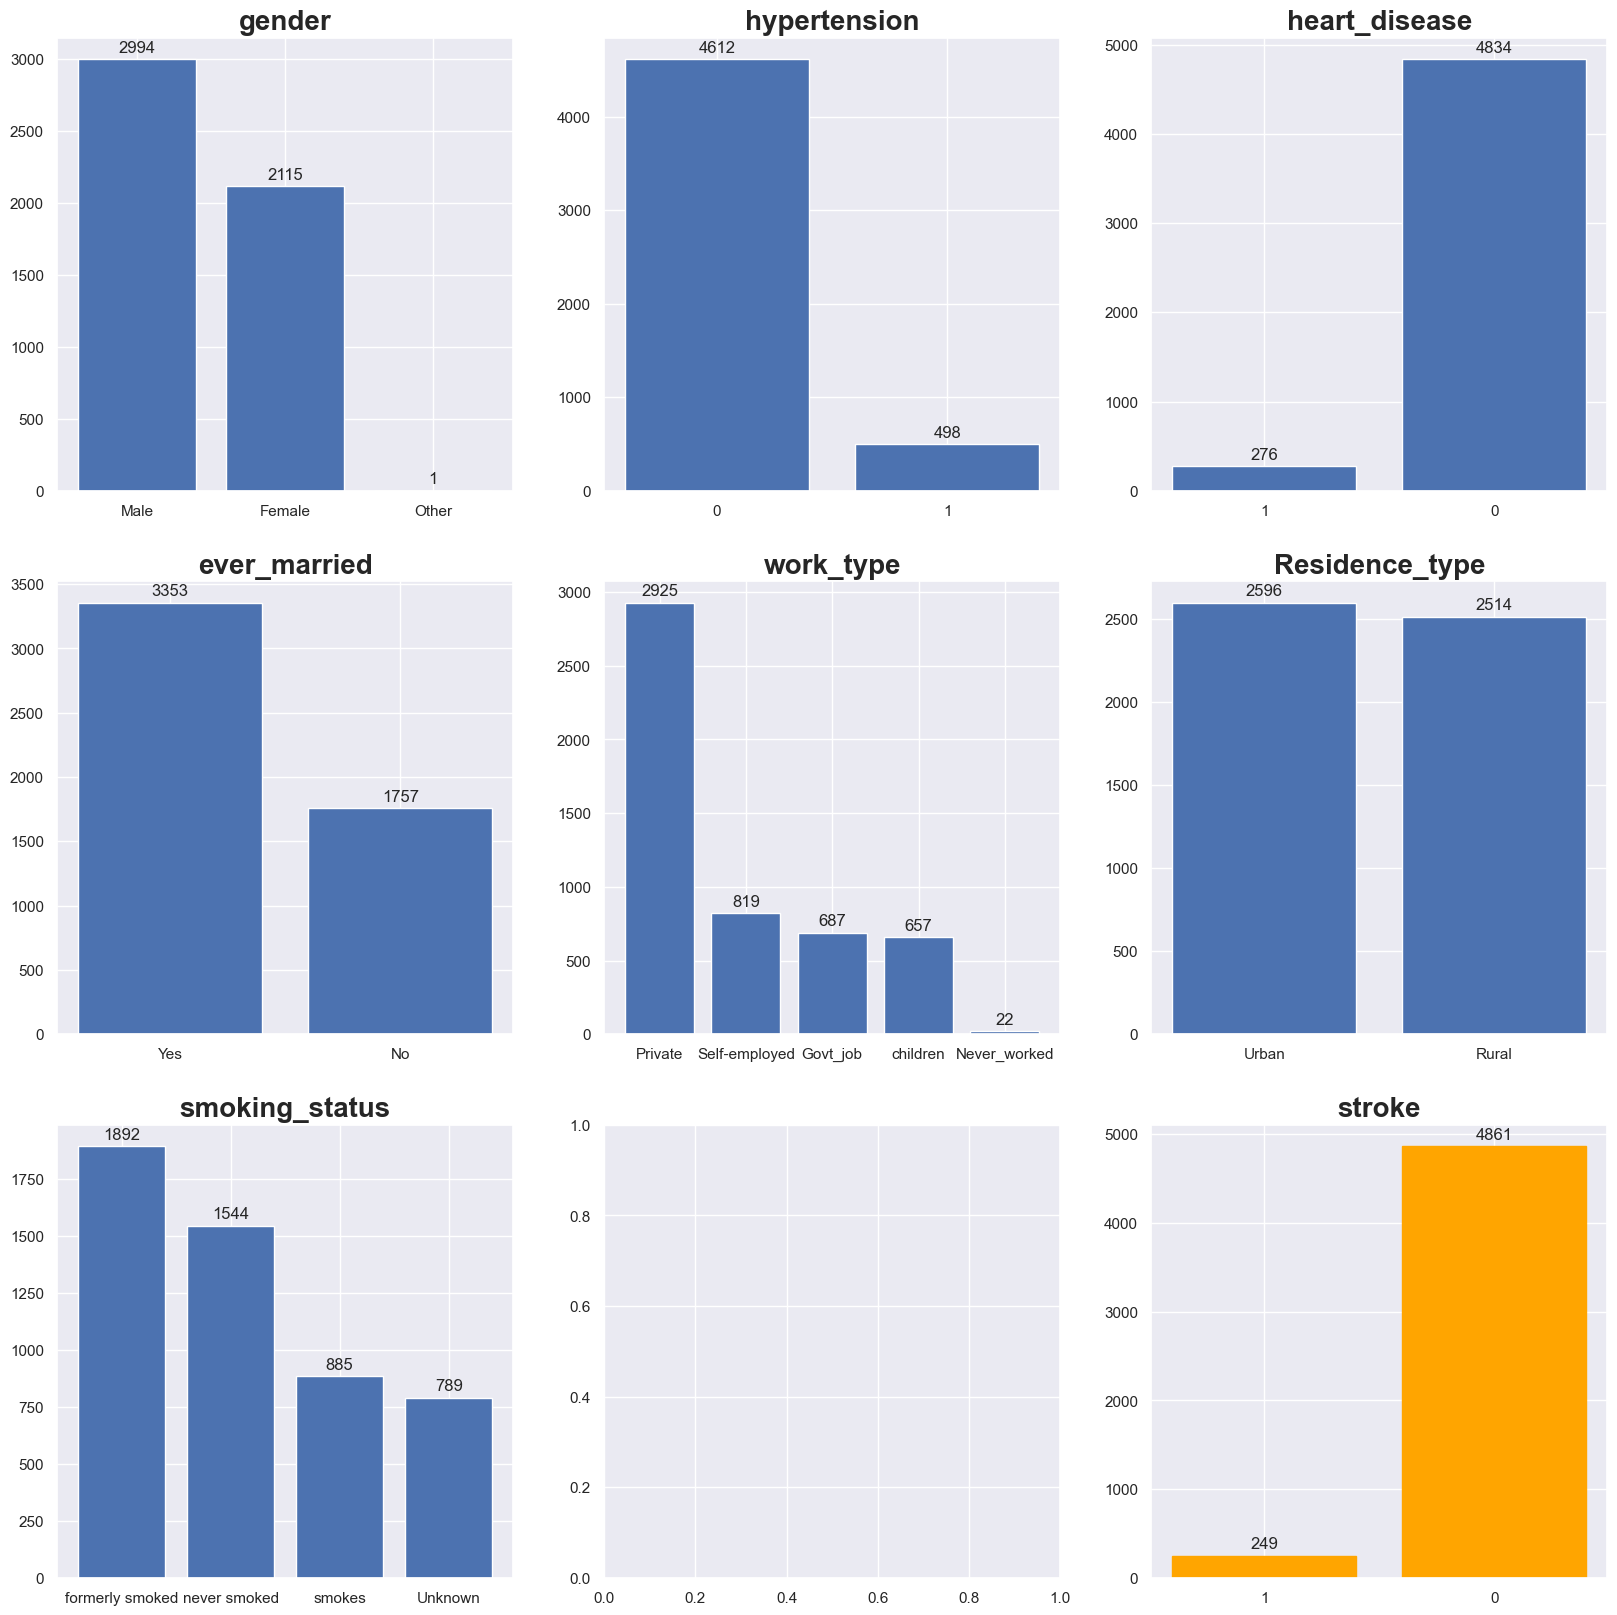

In [5]:
# Finding Categorical Features and Target
categorical = df.select_dtypes(include=["object", "int64"]).columns
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
i = 0
for column in categorical:
    if column == "stroke":
        i += 1
    bars = axes[i // 3, i % 3].bar(x=df[column].unique(), height=df[column].value_counts())
    axes[i // 3, i % 3].set_title(column, fontweight="bold", fontsize=20)
    axes[i // 3, i % 3].set_xticks(ticks=[i  for i in range(len(df[column].unique()))], labels=df[column].unique())
    for bar in bars:
        if column == "stroke":
            bar.set_color("orange")
        height = bar.get_height()
        axes[i // 3, i % 3].annotate(f"{height}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    i += 1
plt.show()

1. The "Other" category in "Gender" feature has came only one time. Since the target value for this category is zero which is the more common target, we'd better remove this sample.

2. The "Never Worked" category in "Work_type" feature exists considerably lower than other categories. So we should be careful sampling from our dataset in order to balance it.

3. The "0" category in target column exists about 20 times more than "1" category. So we're facing an extremely imbalanced data. We have to use undersampling or oversampling in our modeling.

In [6]:
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
df["gender"].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

### Analyzing Numerical Features

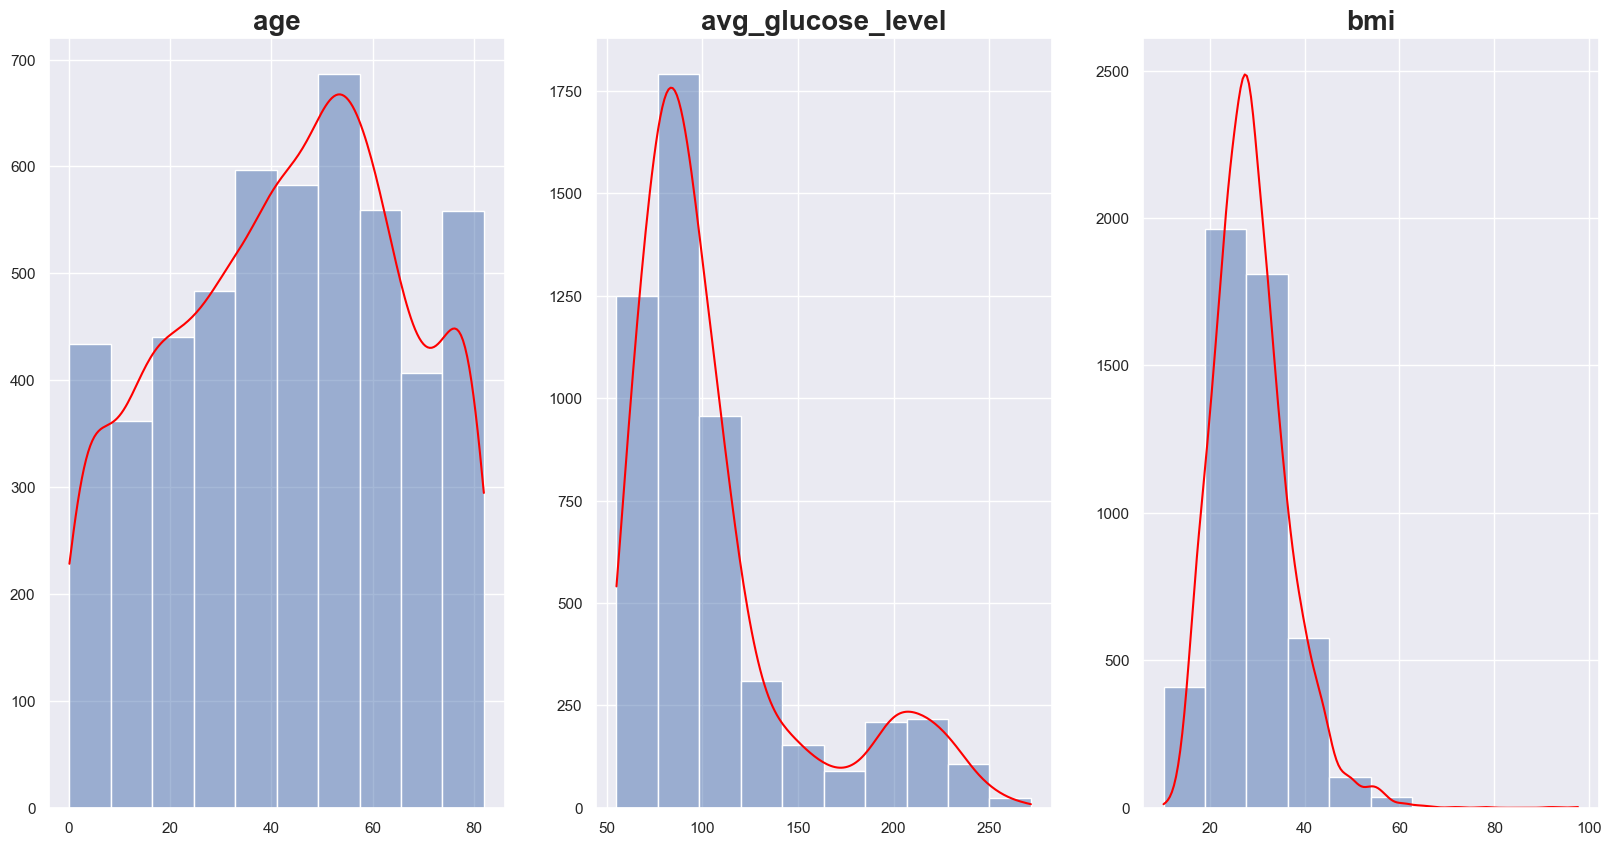

In [7]:
# Finding Numerical Features
numerical = df.select_dtypes(include="float64").columns
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
i = 0
for column in numerical:
    hist = sns.histplot(data=df[column], kde=True, ax=axes[i % 3], bins=10)
    hist.lines[0].set_color("red")
    hist.set_title(column, fontweight="bold", fontsize=20)
    hist.set_xlabel("")
    hist.set_ylabel("")
    i += 1
plt.show()

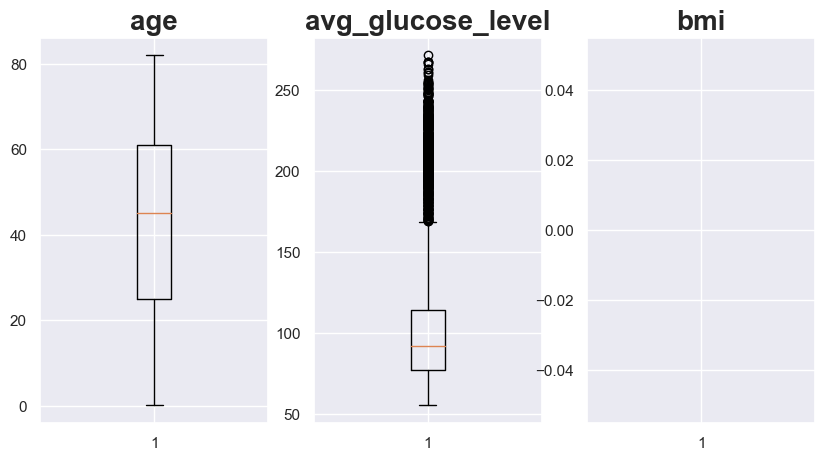

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
i = 0
for column in numerical:
    axes[i % 3].boxplot(df[column])
    axes[i % 3].set_title(column, fontweight="bold", fontsize=20)
    i += 1
plt.show()

1. "Age" feature is quite normal and has no outliers.

2. "Avg_glucose_level" feature has right skewness and many outliers. So the RobustScaler will be better for standardization.

3. "BMI" feature has missing values. It has right skewness so we need to use non-parametric outlier detection to decide about imputing missing values.

In [9]:
q1 = df["bmi"].quantile(0.25)
q3 = df["bmi"].quantile(0.75)
iqr = q3 - q1
bmi_outliers = df["bmi"][(df["bmi"] < q1 - 1.5 * iqr) | (df["bmi"] > q3 + 1.5 * iqr)]
print(f"BMI Outliers: {bmi_outliers.shape[0]}")

BMI Outliers: 110


Since "BMI" feature has outliers, we'd better use "median" strategy for imputation.

# 3. Data Preprocessing

In this section we apply some temporary changes to our dataset to visualize data. We're going to reapply the best changes in our pipeline in modeling section in order to avoid data leakage.

### Checking for Missing Values

In [10]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [11]:
# Checking Target Value for Samples with Missing Values
df[df["bmi"].isnull()].stroke.value_counts()

stroke
0    161
1     40
Name: count, dtype: int64

In [12]:
# Imputing Missing Values
df[["bmi"]] = SimpleImputer(strategy="median").fit_transform(df[["bmi"]])
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Checking for Duplicated Samples

In [13]:
if not len(df[df.duplicated()]):
    print("There are no duplicated samples.")
df[df.duplicated()]

There are no duplicated samples.


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [14]:
categorical = df.select_dtypes(include="object").columns
df[categorical] = OrdinalEncoder().fit_transform(df[categorical])
df[categorical].head()

,gender,ever_married,work_type,Residence_type,smoking_status
1,1.0,1.0,2.0,1.0,1.0
2,0.0,1.0,3.0,0.0,2.0
3,1.0,1.0,2.0,0.0,2.0
4,0.0,1.0,2.0,1.0,3.0
5,0.0,1.0,3.0,0.0,2.0


### Checking Correlation between Features and Target

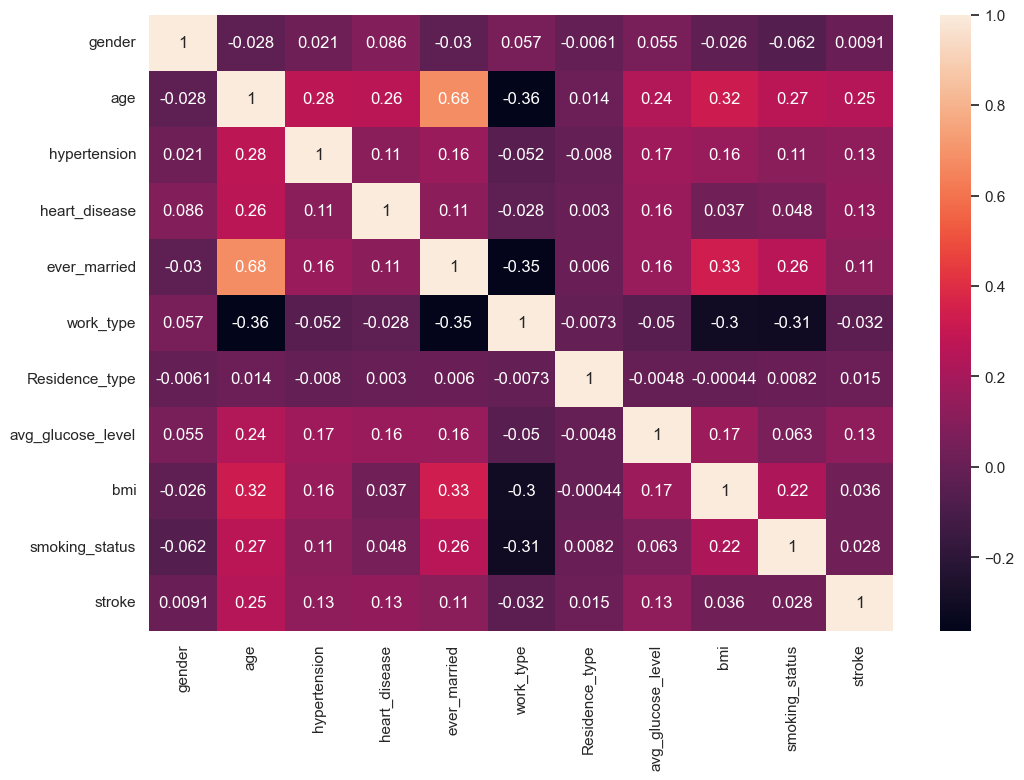

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

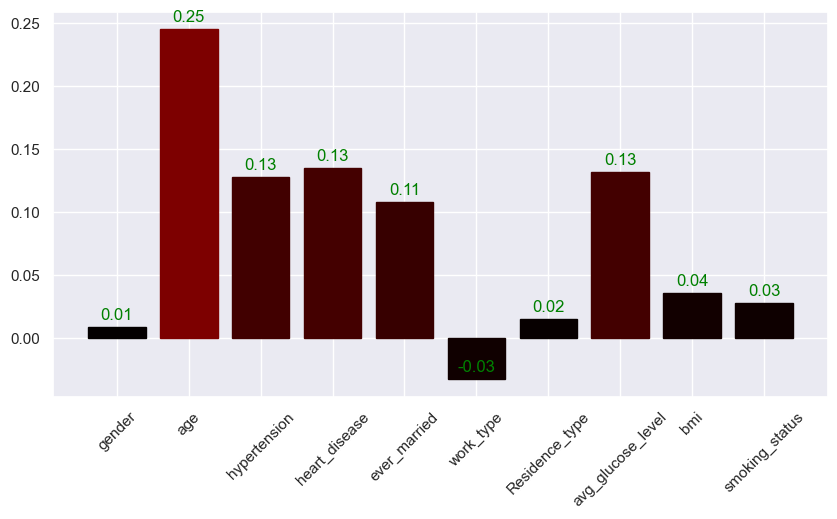

In [16]:
plt.figure(figsize=(10, 5))
bars = plt.bar(x=df.columns[:-1] , height=df.corr().iloc[:-1, -1])
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', color="green")
    bar.set_color(f"#{int((abs(height) / 0.5) * 255):02X}0000")
plt.show()

1. The "Age" feature has the most correlation with the target.
2. "Avg_glucose_level" is the second numerical feature which has the most correlation with the target.

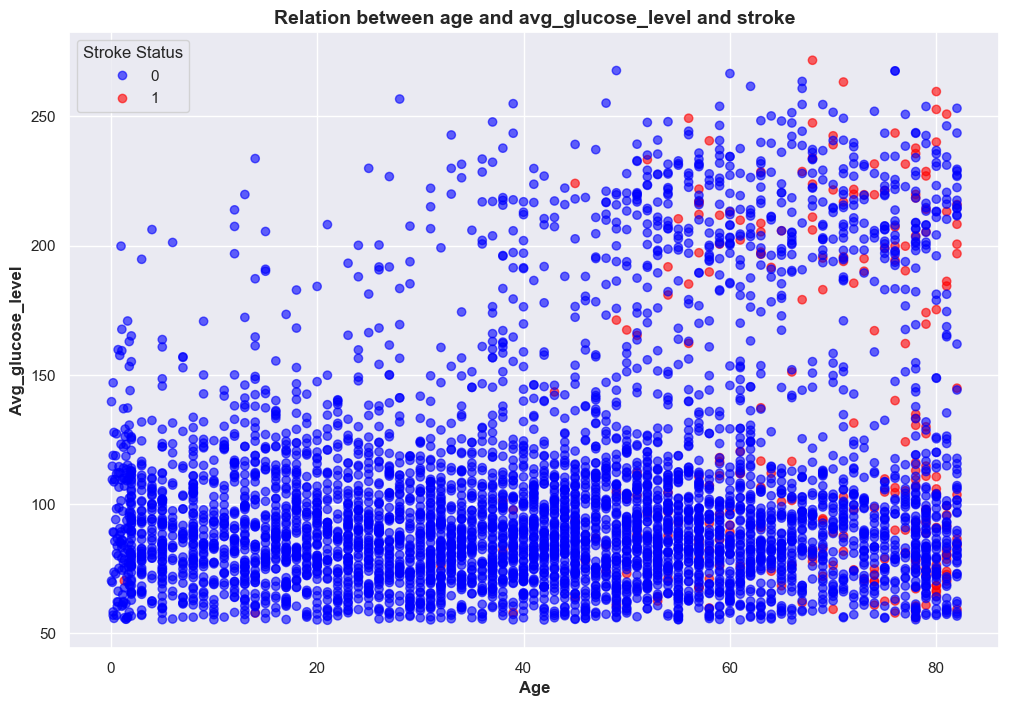

In [17]:
plt.figure(figsize=(12, 8))
sns.set_style("darkgrid")
scatter = plt.scatter(x=df["age"], y=df["avg_glucose_level"], alpha=0.6, c=df["stroke"], cmap="bwr")
plt.legend(*scatter.legend_elements(), loc="best", title="Stroke Status")
plt.title("Relation between age and avg_glucose_level and stroke", fontsize=14, fontweight="bold")
plt.xlabel("Age", fontweight="bold")
plt.ylabel("Avg_glucose_level", fontweight="bold")
plt.show()

We can categorize data in two clusters. The higher the "Age" and "avg_glucose_level" are, the greater the probability of stroke.

### Age Transformation

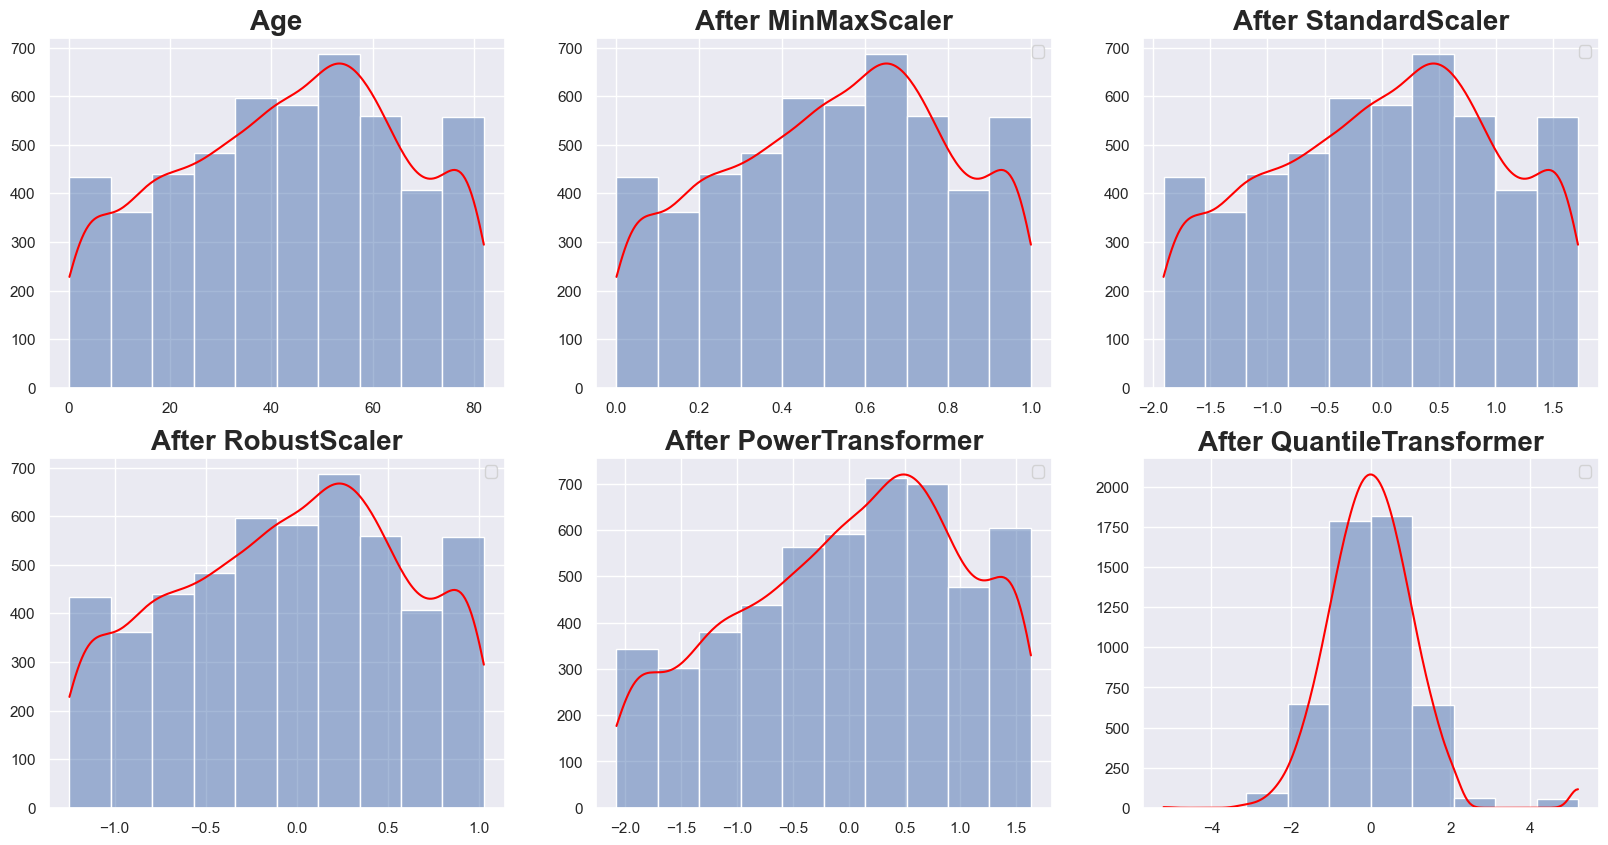

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
hist = sns.histplot(data=df["age"], kde=True, bins=10, ax=axes[0, 0])
hist.lines[0].set_color("red")
hist.set_title("Age", fontweight="bold", fontsize=20)
hist.set_xlabel("")
hist.set_ylabel("")
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler(), PowerTransformer(), QuantileTransformer(output_distribution="normal")]
i = 1
for scaler in scalers:
    df_t = scaler.fit_transform(df[["age"]])
    hist = sns.histplot(data=df_t, kde=True, bins=10, ax=axes[i // 3, i % 3])
    hist.lines[0].set_color("red")
    hist.set_title(f"After {scaler.__class__.__name__}", fontweight="bold", fontsize=20)
    hist.set_xlabel("")
    hist.set_ylabel("")
    hist.legend("")
    i += 1
plt.show()

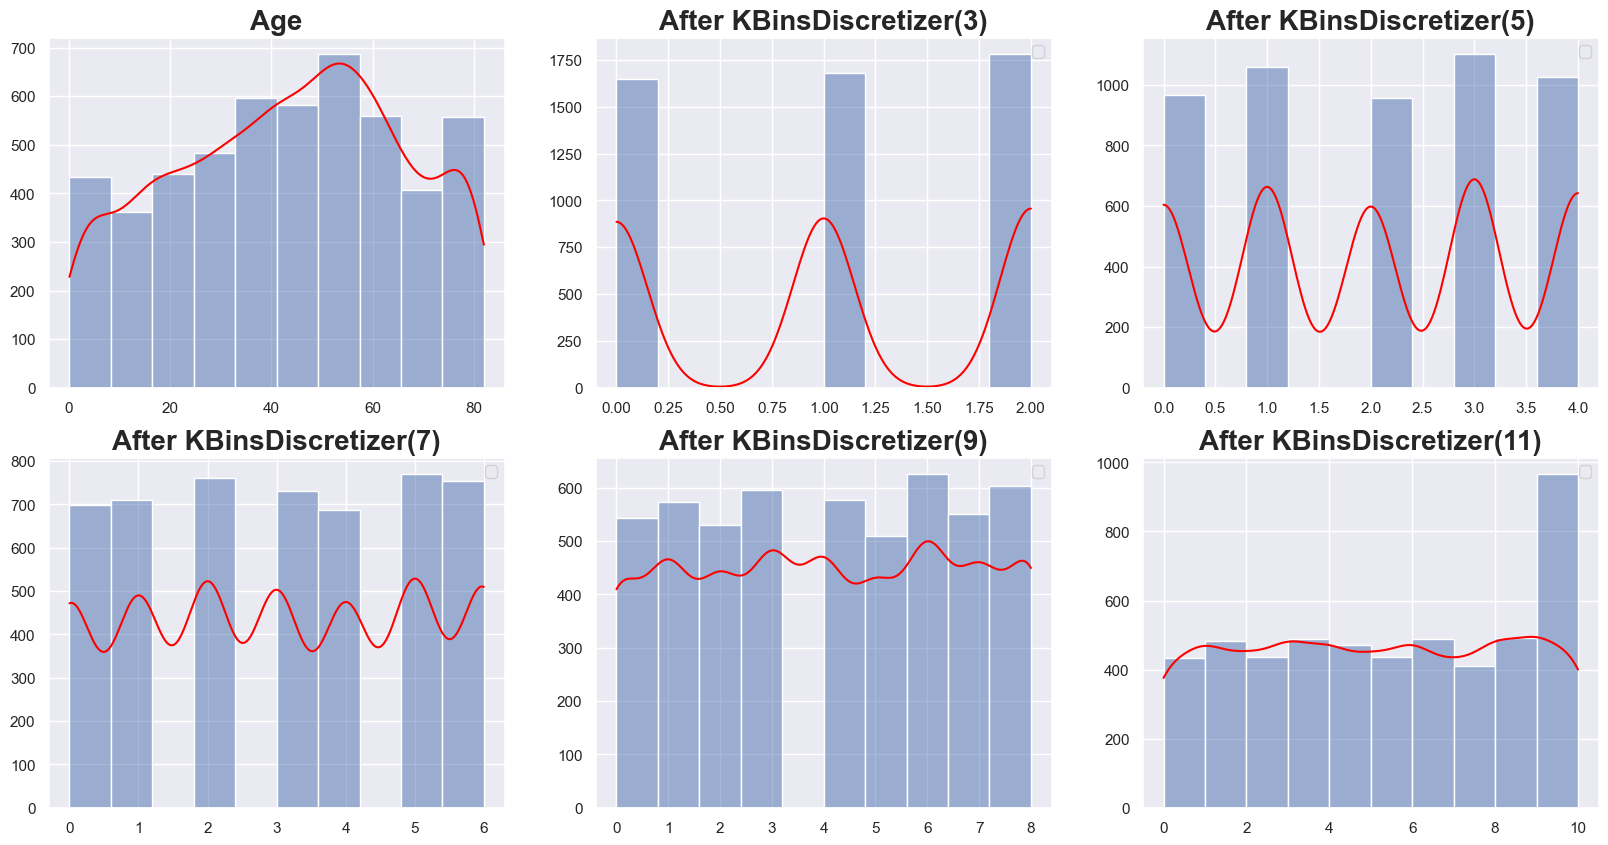

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
hist = sns.histplot(data=df["age"], kde=True, bins=10, ax=axes[0, 0])
hist.lines[0].set_color("red")
hist.set_title("Age", fontweight="bold", fontsize=20)
hist.set_xlabel("")
hist.set_ylabel("")
scalers = [KBinsDiscretizer(n_bins=i, encode="ordinal") for i in range(3, 12, 2)]
i = 1
for scaler in scalers:
    df_t = scaler.fit_transform(df[["age"]])
    hist = sns.histplot(data=df_t, kde=True, bins=10, ax=axes[i // 3, i % 3])
    hist.lines[0].set_color("red")
    hist.set_title(f"After {scaler.__class__.__name__}({scaler.get_params()['n_bins']})", fontweight="bold", fontsize=20)
    hist.set_xlabel("")
    hist.set_ylabel("")
    hist.legend("")
    i += 1
plt.show()

### Avg_glucose_level Transformation

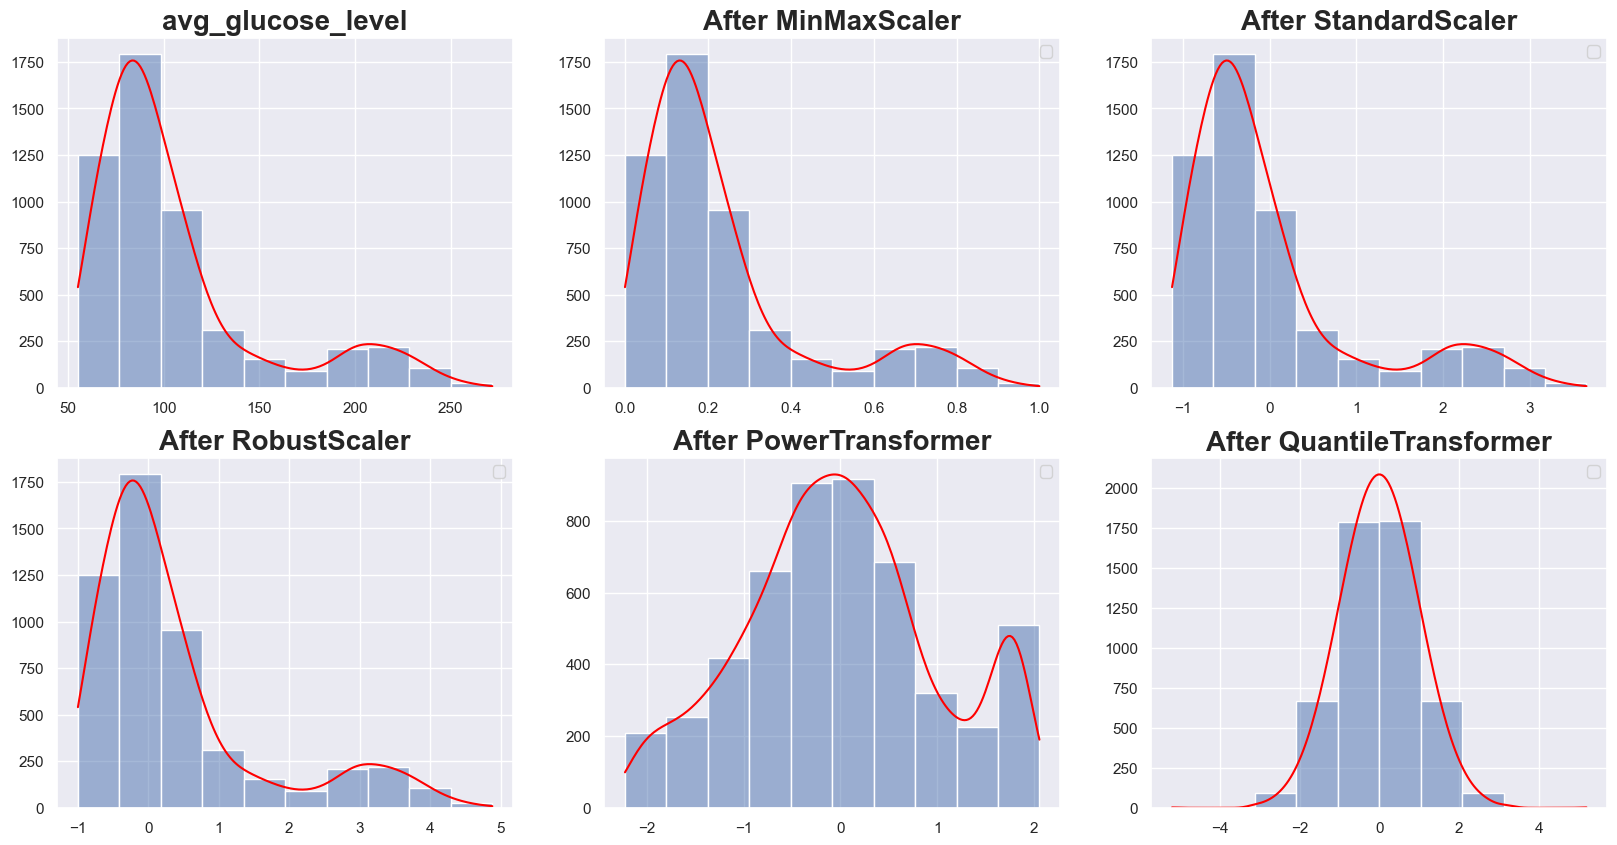

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
hist = sns.histplot(data=df["avg_glucose_level"], kde=True, bins=10, ax=axes[0, 0])
hist.lines[0].set_color("red")
hist.set_title("avg_glucose_level", fontweight="bold", fontsize=20)
hist.set_xlabel("")
hist.set_ylabel("")
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler(), PowerTransformer(), QuantileTransformer(output_distribution="normal")]
i = 1
for scaler in scalers:
    df_t = scaler.fit_transform(df[["avg_glucose_level"]])
    hist = sns.histplot(data=df_t, kde=True, bins=10, ax=axes[i // 3, i % 3])
    hist.lines[0].set_color("red")
    hist.set_title(f"After {scaler.__class__.__name__}", fontweight="bold", fontsize=20)
    hist.set_xlabel("")
    hist.set_ylabel("")
    hist.legend("")
    i += 1
plt.show()

### BMI Transformation

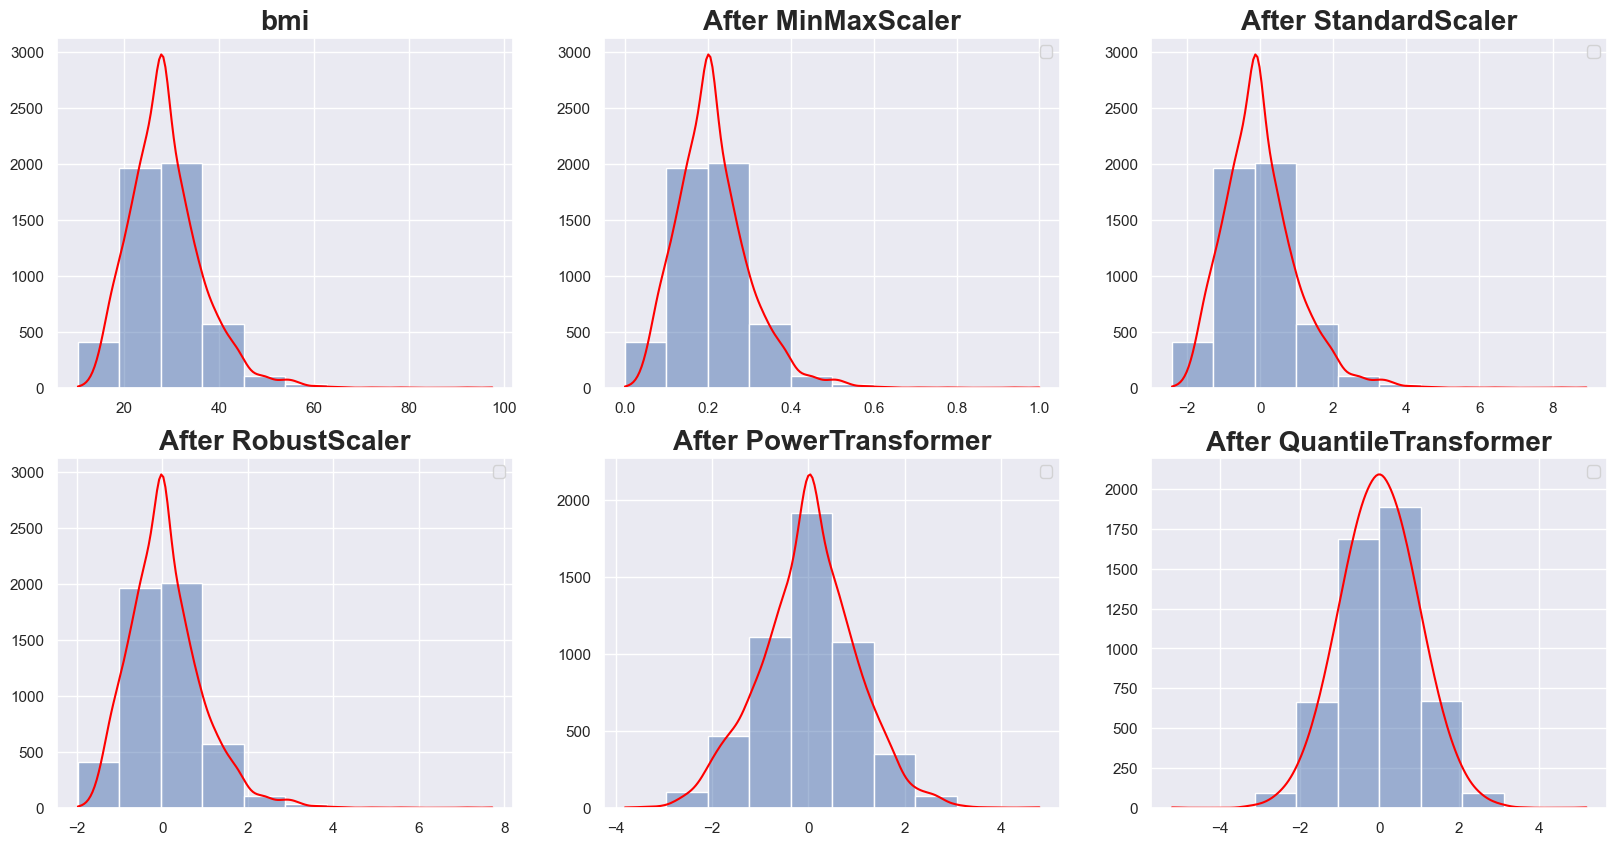

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
hist = sns.histplot(data=df["bmi"], kde=True, bins=10, ax=axes[0, 0])
hist.lines[0].set_color("red")
hist.set_title("bmi", fontweight="bold", fontsize=20)
hist.set_xlabel("")
hist.set_ylabel("")
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler(), PowerTransformer(), QuantileTransformer(output_distribution="normal")]
i = 1
for scaler in scalers:
    df_t = scaler.fit_transform(df[["bmi"]])
    hist = sns.histplot(data=df_t, kde=True, bins=10, ax=axes[i // 3, i % 3])
    hist.lines[0].set_color("red")
    hist.set_title(f"After {scaler.__class__.__name__}", fontweight="bold", fontsize=20)
    hist.set_xlabel("")
    hist.set_ylabel("")
    hist.legend("")
    i += 1
plt.show()

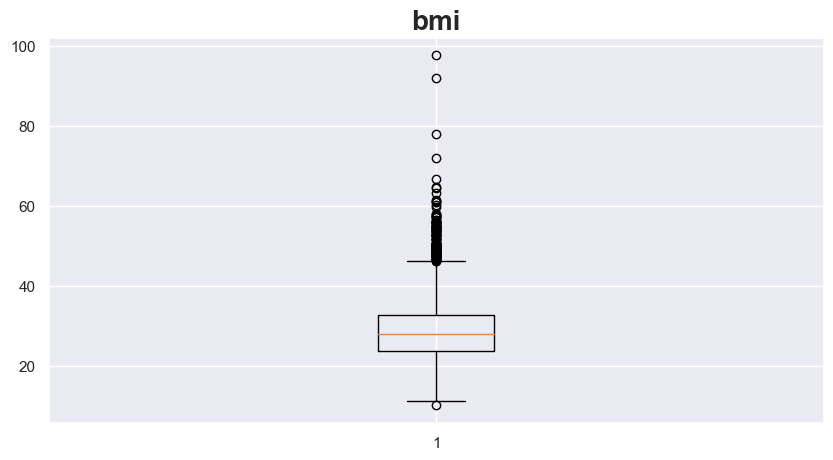

In [22]:
plt.figure(figsize=(10, 5))
plt.boxplot(df["bmi"])
plt.title("bmi", fontweight="bold", fontsize=20)
plt.show()

# 4. Modeling

c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


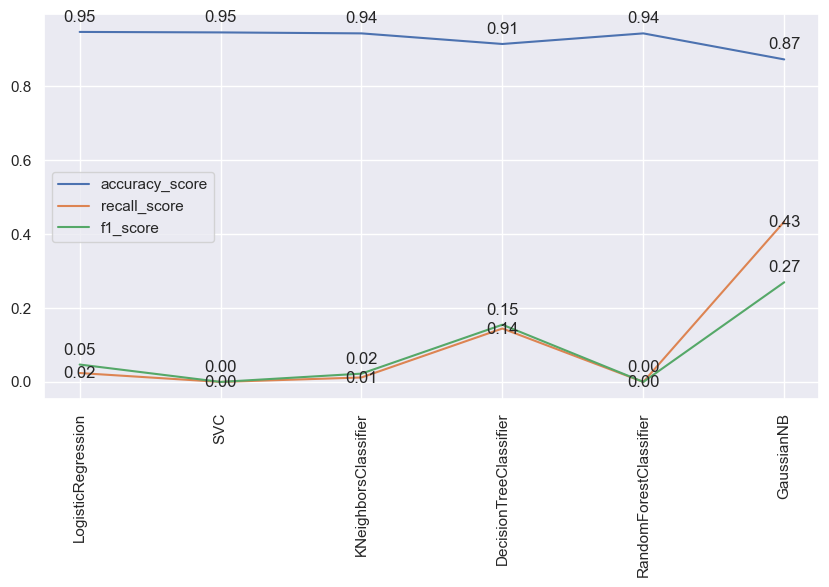

In [66]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Samples and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# Encoding Categorical Features
categorical = X.select_dtypes(include="object").columns
encoder = OrdinalEncoder()
X_train[categorical] = encoder.fit_transform(X_train[categorical])
X_test[categorical] = encoder.transform(X_test[categorical])
# Imputing Missing Values with "median" Strategy
imputer = SimpleImputer(strategy="median")
X_train[["bmi"]] = imputer.fit_transform(X_train[["bmi"]])
X_test[["bmi"]] = imputer.transform(X_test[["bmi"]])
# Checking Accuracy and Recall Score with Different Models
models = [LogisticRegression(), SVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]
names, accuracy_scores, recall_scores, f1_scores, confusion_matrixes = list(), list(), list(), list(), list()
for model in models:
    names.append(model.__class__.__name__)
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_prediction)
    accuracy_scores.append(accuracy)
    recall = recall_score(y_test, y_prediction)
    recall_scores.append(recall)
    f1 = f1_score(y_test, y_prediction)
    f1_scores.append(f1)
    matrix = confusion_matrix(y_test, y_prediction)
    confusion_matrixes.append(matrix)
# Comparing Different Models
plt.figure(figsize=[10, 5])
plt.plot(names, accuracy_scores, label="accuracy_score")
plt.plot(names, recall_scores, label="recall_score")
plt.plot(names, f1_scores, label="f1_score")
plt.xticks(rotation=90)
plt.legend(loc="best")
for name, accuracy, recall, f1 in zip(names, accuracy_scores, recall_scores, f1_scores):
    plt.annotate(f"{accuracy:.2f}", xy=(name, accuracy), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    plt.annotate(f"{recall:.2f}", xy=(name, recall), xytext=(0, 5), textcoords="offset points", ha='center', va='top')
    plt.annotate(f"{f1:.2f}", xy=(name, f1), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
plt.show()

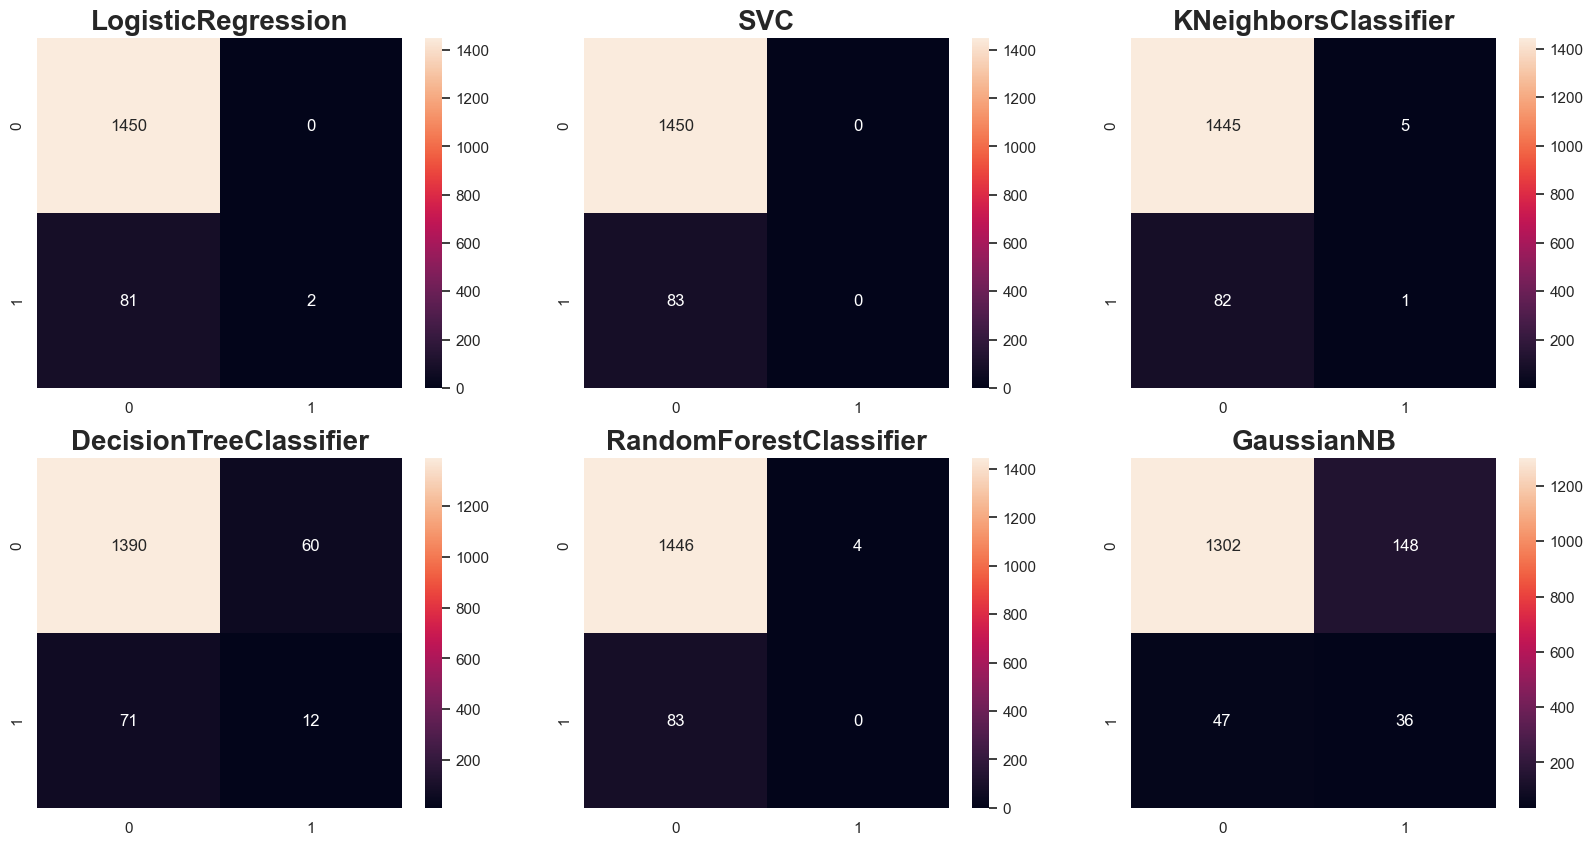

In [67]:
# Visualizing Confusion Matrixes
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
i = 0
for name, matrix in zip(names, confusion_matrixes):
    heatmap = sns.heatmap(matrix, annot=True, fmt="d", ax=axes[i // 3, i % 3])
    heatmap.set_title(name, fontweight="bold", fontsize=20)
    i += 1
plt.show()

In [60]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Samples and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Defining Column Transformer
categorical = X.select_dtypes(include="object").columns
preprocessor = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical),
                                               ("imputer", SimpleImputer(strategy="median"), ["bmi"])],
                                 remainder="passthrough")
# Generating Pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", GaussianNB())])
# Calculating Cross Validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Calculating Accuracy Score
accuracy_scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
accuracy = mean(accuracy_scores)
print(f"Accuracy Score: {accuracy:.2%}")
# Calculating Recall Score
recall_scores = cross_val_score(pipeline, X, y, scoring="recall", cv=cv, n_jobs=-1)
recall = mean(recall_scores)
print(f"Recall Score: {recall:.2%}")
# Calculating F1 Score
f1_scores = cross_val_score(pipeline, X, y, scoring="f1", cv=cv, n_jobs=-1)
f1 = mean(f1_scores)
print(f"F1 Score: {f1:.2%}")

Accuracy Score: 86.58%
Recall Score: 39.01%
F1 Score: 22.04%


We're going to use undersampling to balance the data, because Recall Score and F1 Score are very low.

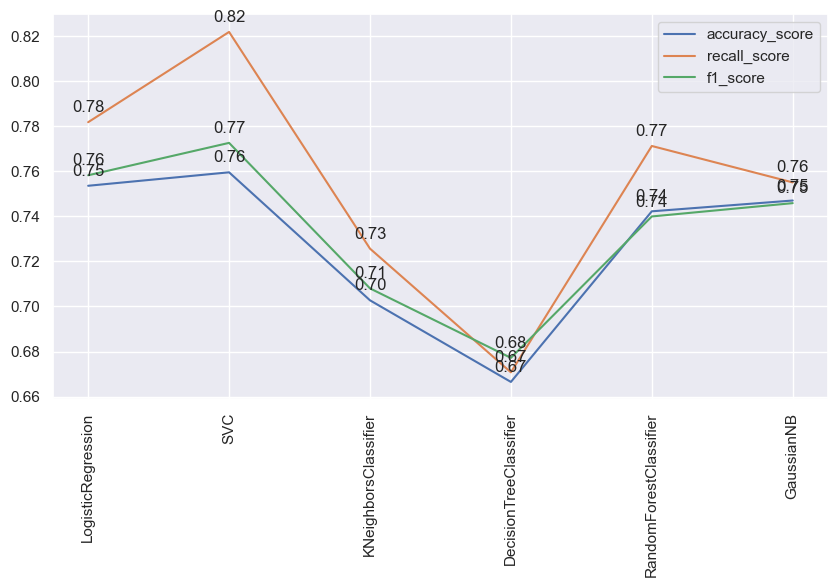

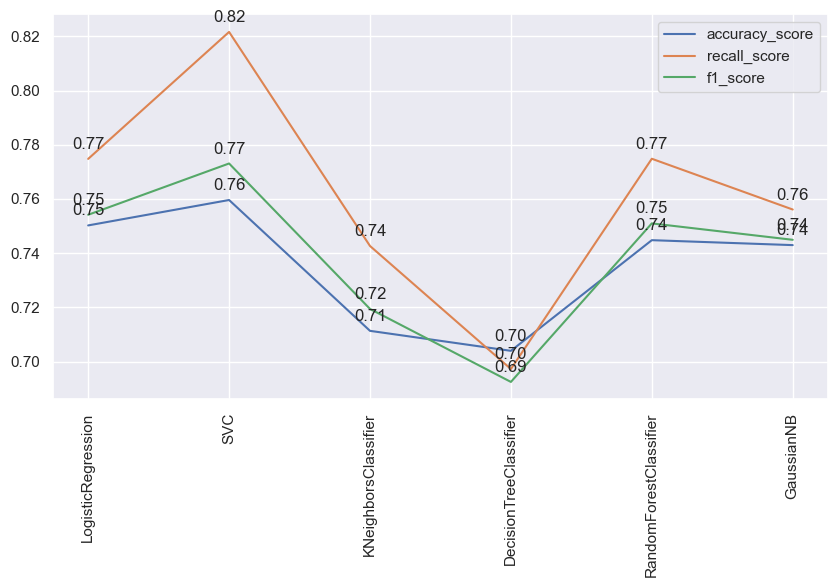

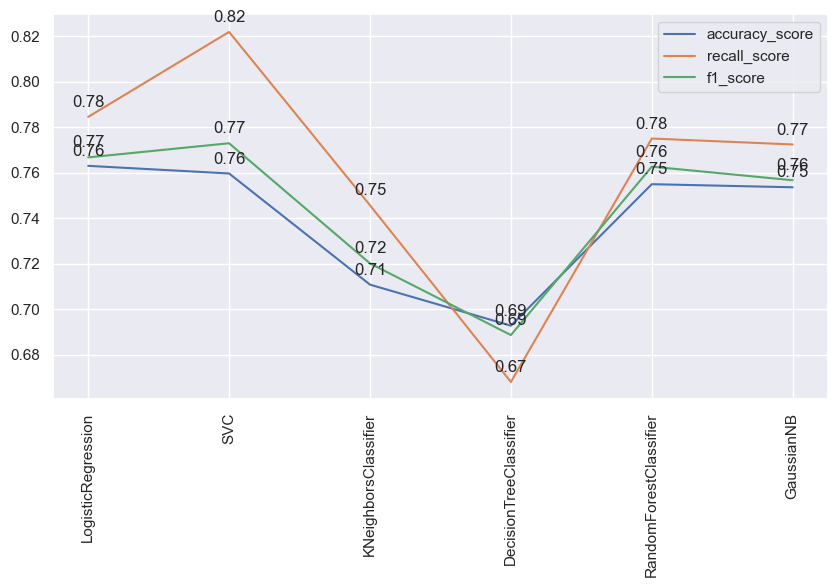

In [69]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Sampling from Data in order to Balance it
for _ in range(3):
    df1 = df[df["stroke"] == 1]
    balance_count = df1.shape[0]
    df0 = df[df["stroke"] == 0].sample(balance_count - 2)
    df0_1 = df[(df["stroke"] == 0) & (df["work_type"] == "Never_worked")].sample(2)
    df = concat([df0, df1, df0_1], axis=0).sample(frac=1)
    # Splitting Data into Samples and Target
    X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
    # Defining Column Transformer
    categorical = X.select_dtypes(include="object").columns
    preprocessor = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical),
                                                   ("imputer", SimpleImputer(strategy="median"), ["bmi"])],
                                     remainder="passthrough")
    # Calculating Cross Validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Generating Pipeline with Different Models
    models = [LogisticRegression(), SVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]

    names, accuracy_scores, recall_scores, f1_scores = list(), list(), list(), list()
    for model in models:
        names.append(model.__class__.__name__)
        pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("model", model)])
        accuracy = mean(cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv, n_jobs=-1))
        accuracy_scores.append(accuracy)
        recall = mean(cross_val_score(pipeline, X, y, scoring="recall", cv=cv, n_jobs=-1))
        recall_scores.append(recall)
        f1 = mean(cross_val_score(pipeline, X, y, scoring="f1", cv=cv, n_jobs=-1))
        f1_scores.append(f1)
    # Comparing Different Models
    plt.figure(figsize=[10, 5])
    plt.plot(names, accuracy_scores, label="accuracy_score")
    plt.plot(names, recall_scores, label="recall_score")
    plt.plot(names, f1_scores, label="f1_score")
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    for name, accuracy, recall, f1 in zip(names, accuracy_scores, recall_scores, f1_scores):
        plt.annotate(f"{accuracy:.2f}", xy=(name, accuracy), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
        plt.annotate(f"{recall:.2f}", xy=(name, recall), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
        plt.annotate(f"{f1:.2f}", xy=(name, f1), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    plt.show()

Based on above charts, SVC has the best scores among different models.
We're going to find the best sample through a for loop with SVC model.

In [75]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Finding Best Sample
best_df = DataFrame()
max_average, max_accuracy, max_recall, max_f1 = 0, 0, 0, 0
for _ in range(100):
    df1 = df[df["stroke"] == 1]
    balance_count = df1.shape[0]
    df0 = df[df["stroke"] == 0].sample(balance_count - 2)
    df0_1 = df[(df["stroke"] == 0) & (df["work_type"] == "Never_worked")].sample(2)
    df = concat([df0, df1, df0_1], axis=0).sample(frac=1)
    # Splitting Data into Samples and Target
    X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
    # Defining Column Transformer
    categorical = X.select_dtypes(include="object").columns
    preprocessor = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical),
                                                   ("imputer", SimpleImputer(strategy="median"), ["bmi"])],
                                     remainder="passthrough")
    # Calculating Cross Validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Generating Pipeline with SVC
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("model", SVC())])
    accuracy = mean(cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv, n_jobs=-1))
    recall = mean(cross_val_score(pipeline, X, y, scoring="recall", cv=cv, n_jobs=-1))
    f1 = mean(cross_val_score(pipeline, X, y, scoring="f1", cv=cv, n_jobs=-1))
    average = (accuracy + recall + f1) / 3
    if average > max_average:
        best_df = df
        max_average, max_accuracy, max_recall, max_f1 = average, accuracy, recall, f1
print(f"Best Accuracy: {max_accuracy:.2%}")
print(f"Best Recall: {max_recall:.2%}")
print(f"Best F1: {max_f1:.2%}")
print("Best Sample:")
best_df

Best Accuracy: 88.07%
Best Recall: 93.97%
Best F1: 88.78%
Best Sample:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3973,Male,15.0,0,0,No,Never_worked,Urban,64.29,16.7,Unknown,0
20,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
39,Male,58.0,0,0,No,Private,Rural,92.62,32.0,Unknown,1
207,Female,81.0,0,0,Yes,Private,Rural,80.13,23.4,never smoked,1
2347,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
85,Male,58.0,0,0,Yes,Private,Urban,71.20,NaN,Unknown,1
182,Male,59.0,0,0,Yes,Private,Urban,111.04,32.0,formerly smoked,1
151,Female,79.0,0,0,Yes,Private,Rural,169.67,NaN,Unknown,1
2347,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0


Saving Best Sample to a csv file

In [76]:
best_df.to_csv("stroke-prediction-best-sample.csv", index=False)

Accuracy: 91.00%
Recall: 92.86%
F1: 92.04%


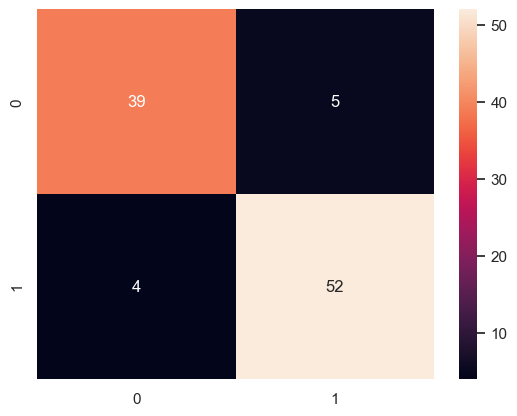

In [19]:
# Loading Best Sample
df = read_csv("stroke-prediction-best-sample.csv")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Splitting Data into Samples and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Defining Column Transformer
categorical = X.select_dtypes(include="object").columns
preprocessor = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical),
                                               ("imputer", SimpleImputer(strategy="median"), ["bmi"])],
                                 remainder="passthrough")
# Generating Pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", SVC())])
pipeline.fit(X_train, y_train)
y_prediction = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_prediction)
recall = recall_score(y_test, y_prediction)
f1 = f1_score(y_test, y_prediction)
matrix = confusion_matrix(y_test, y_prediction)
print(f"Accuracy: {accuracy:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1: {f1:.2%}")
sns.heatmap(matrix, annot=True, fmt="d")
plt.show()

Accuracy: 55.47%
Recall: 93.57%
F1: 17.00%


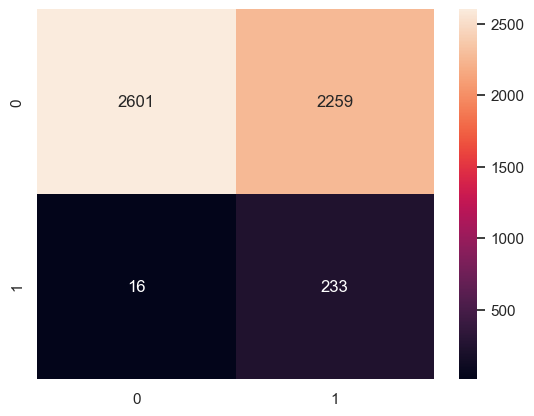

In [44]:
# Loading Best Sample as Train Section
df_train = read_csv("stroke-prediction-best-sample.csv")
# Setting Index Values
df_train.index = range(1, df_train.shape[0] + 1)
# Splitting Train Section into Samples and Target
X_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1].astype(int)
# Defining Column Transformer
categorical = X.select_dtypes(include="object").columns
preprocessor = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical),
                                               ("imputer", SimpleImputer(strategy="median"), ["bmi"])],
                                 remainder="passthrough")
# Generating Pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", SVC())])
pipeline.fit(X_train, y_train)
# Loading the Whole Dataset as Test Section
df_test = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df_test.index = range(1, df_test.shape[0] + 1)
# Removing Ineffective Column
df_test.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df_test.drop(df_test[df_test["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Test Section into Samples and Target
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1].astype(int)
y_prediction = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_prediction)
recall = recall_score(y_test, y_prediction)
f1 = f1_score(y_test, y_prediction)
matrix = confusion_matrix(y_test, y_prediction)
print(f"Accuracy: {accuracy:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1: {f1:.2%}")
sns.heatmap(matrix, annot=True, fmt="d")
plt.show()

However the best sample obtained good scores, it can't predict the whole samples accurately. So we're going to use another method to find the best sample.

c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


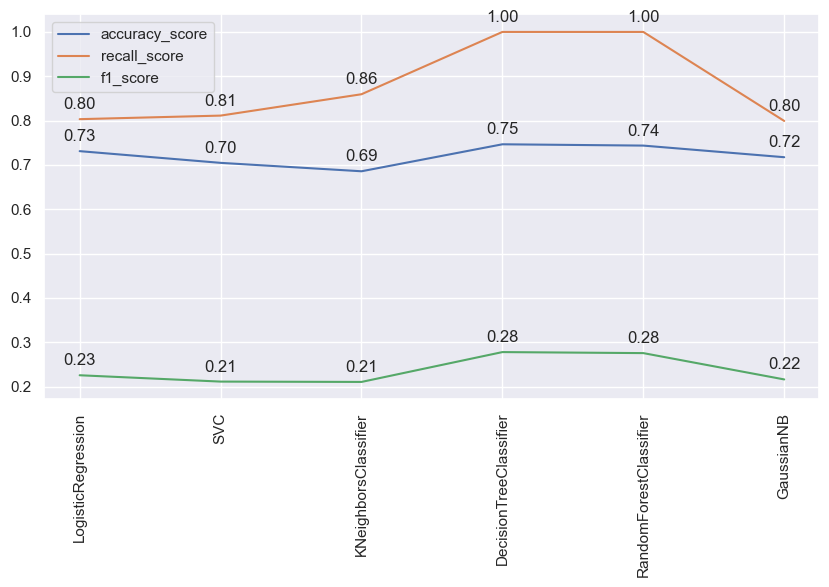

c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


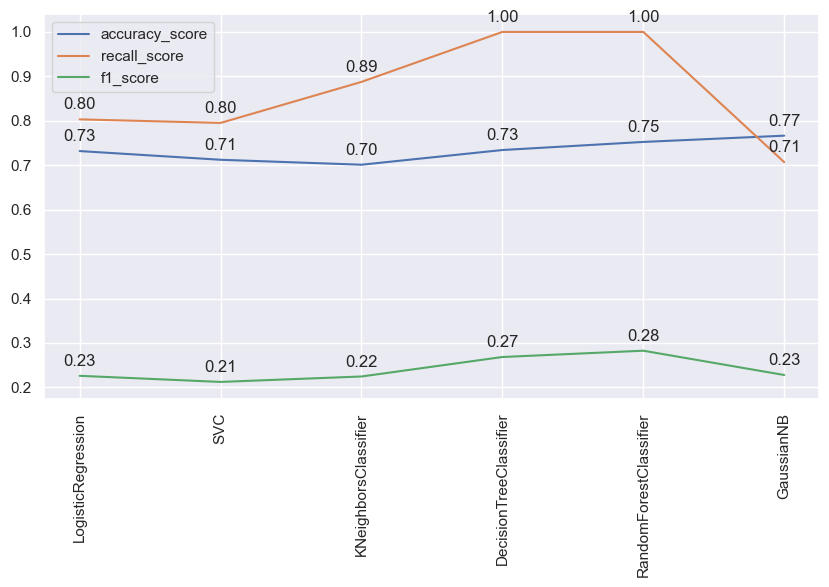

c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


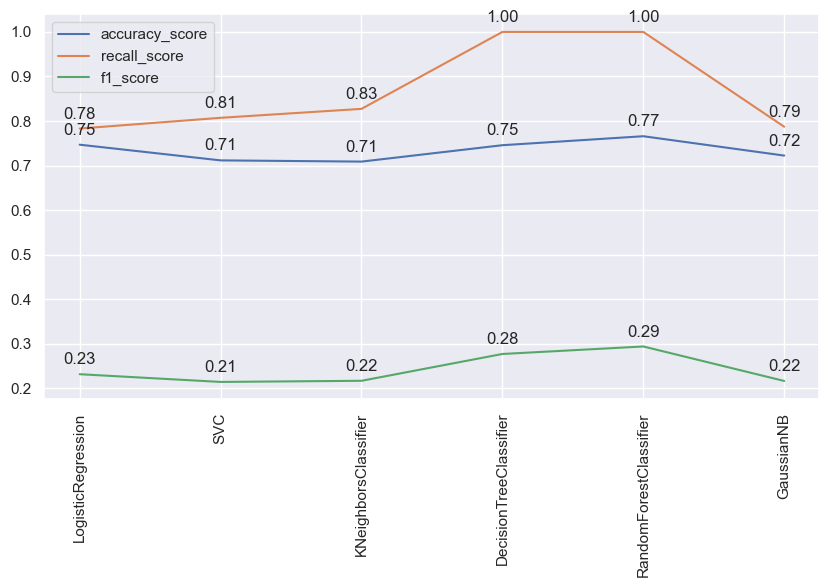

In [29]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Test Section into Samples and Target
X_test, y_test = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Sampling from Data in order to Balance it
for _ in range(3):
    df1 = df[df["stroke"] == 1]
    balance_count = df1.shape[0]
    df0 = df[df["stroke"] == 0].sample(balance_count - 2)
    df0_1 = df[(df["stroke"] == 0) & (df["work_type"] == "Never_worked")].sample(2)
    df_train = concat([df0, df1, df0_1], axis=0).sample(frac=1)
    # Splitting Data into Samples and Target
    X_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1].astype(int)
    # Defining Column Transformer
    categorical = X_train.select_dtypes(include="object").columns
    preprocessor = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical),
                                                   ("imputer", SimpleImputer(strategy="median"), ["bmi"])],
                                     remainder="passthrough")
    # Generating Pipeline with Different Models
    models = [LogisticRegression(), SVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]
    names, accuracy_scores, recall_scores, f1_scores = list(), list(), list(), list()
    for model in models:
        names.append(model.__class__.__name__)
        pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                   ("model", model)])
        pipeline.fit(X_train, y_train)
        y_prediction = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_prediction)
        accuracy_scores.append(accuracy)
        recall = recall_score(y_test, y_prediction)
        recall_scores.append(recall)
        f1 = f1_score(y_test, y_prediction)
        f1_scores.append(f1)
    # Comparing Different Models
    plt.figure(figsize=[10, 5])
    plt.plot(names, accuracy_scores, label="accuracy_score")
    plt.plot(names, recall_scores, label="recall_score")
    plt.plot(names, f1_scores, label="f1_score")
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    for name, accuracy, recall, f1 in zip(names, accuracy_scores, recall_scores, f1_scores):
        plt.annotate(f"{accuracy:.2f}", xy=(name, accuracy), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
        plt.annotate(f"{recall:.2f}", xy=(name, recall), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
        plt.annotate(f"{f1:.2f}", xy=(name, f1), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    plt.show()

Based on above charts, RandomForestClassifier has the best scores among different models.
We're going to find the best sample through a for loop with RandomForestClassifier model.

In [31]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Test Section into Samples and Target
X_test, y_test = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Finding Best Sample
best_df = DataFrame()
max_average, max_accuracy, max_recall, max_f1 = 0, 0, 0, 0
for _ in range(100):
    df1 = df[df["stroke"] == 1]
    balance_count = df1.shape[0]
    df0 = df[df["stroke"] == 0].sample(balance_count - 2)
    df0_1 = df[(df["stroke"] == 0) & (df["work_type"] == "Never_worked")].sample(2)
    df_train = concat([df0, df1, df0_1], axis=0).sample(frac=1)
    # Splitting Data into Samples and Target
    X_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1].astype(int)
    # Defining Column Transformer
    categorical = X.select_dtypes(include="object").columns
    preprocessor = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical),
                                                   ("imputer", SimpleImputer(strategy="median"), ["bmi"])],
                                     remainder="passthrough")
    # Generating Pipeline with SVC
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("model", RandomForestClassifier())])
    pipeline.fit(X_train, y_train)
    y_prediction = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_prediction)
    recall = recall_score(y_test, y_prediction)
    f1 = f1_score(y_test, y_prediction)
    average = (accuracy + recall + f1) / 3
    if average > max_average:
        best_df = df_train
        max_average, max_accuracy, max_recall, max_f1 = average, accuracy, recall, f1
print(f"Best Accuracy: {max_accuracy:.2%}")
print(f"Best Recall: {max_recall:.2%}")
print(f"Best F1: {max_f1:.2%}")
print("Best Sample:")
best_df

Best Accuracy: 76.81%
Best Recall: 100.00%
Best F1: 29.59%
Best Sample:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
173,Female,60.0,0,0,Yes,Private,Urban,97.43,26.4,smokes,1
179,Female,80.0,0,0,Yes,Govt_job,Urban,110.66,NaN,Unknown,1
4458,Female,62.0,1,0,Yes,Self-employed,Rural,261.67,43.0,formerly smoked,0
2920,Male,23.0,0,0,No,Private,Urban,61.96,22.0,smokes,0
87,Male,61.0,0,1,Yes,Private,Rural,111.81,27.3,smokes,1
...,...,...,...,...,...,...,...,...,...,...,...
22,Female,52.0,1,0,Yes,Self-employed,Urban,233.29,48.9,never smoked,1
248,Male,71.0,1,0,Yes,Self-employed,Rural,87.80,NaN,Unknown,1
150,Female,70.0,0,1,Yes,Private,Rural,239.07,26.1,never smoked,1
28,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1


Saving Best Sample to a csv file

In [32]:
best_df.to_csv("stroke-prediction-best-sample-v2.csv", index=False)

Accuracy: 71.00%
Recall: 80.39%
F1: 73.87%


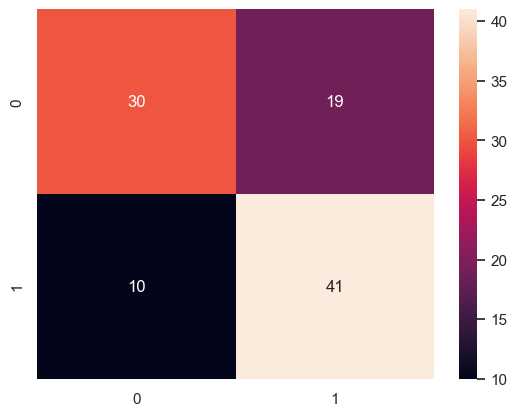

In [34]:
# Loading Best Sample
df = read_csv("stroke-prediction-best-sample-v2.csv")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Splitting Data into Samples and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Defining Column Transformer
categorical = X.select_dtypes(include="object").columns
preprocessor = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical),
                                               ("imputer", SimpleImputer(strategy="median"), ["bmi"])],
                                 remainder="passthrough")
# Generating Pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", RandomForestClassifier())])
pipeline.fit(X_train, y_train)
y_prediction = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_prediction)
recall = recall_score(y_test, y_prediction)
f1 = f1_score(y_test, y_prediction)
matrix = confusion_matrix(y_test, y_prediction)
print(f"Accuracy: {accuracy:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1: {f1:.2%}")
sns.heatmap(matrix, annot=True, fmt="d")
plt.show()

Accuracy: 76.81%
Recall: 100.00%
F1: 29.59%


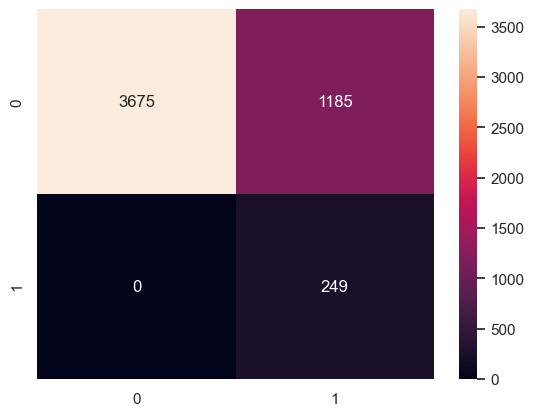

In [43]:
# Loading Best Sample as Train Section
df_train = read_csv("stroke-prediction-best-sample-v2.csv")
# Setting Index Values
df_train.index = range(1, df_train.shape[0] + 1)
# Splitting Train Section into Samples and Target
X_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1].astype(int)
# Defining Column Transformer
categorical = X.select_dtypes(include="object").columns
preprocessor = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical),
                                               ("imputer", SimpleImputer(strategy="median"), ["bmi"])],
                                 remainder="passthrough")
# Generating Pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", RandomForestClassifier())])
pipeline.fit(X_train, y_train)
# Loading the Whole Dataset as Test Section
df_test = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df_test.index = range(1, df_test.shape[0] + 1)
# Removing Ineffective Column
df_test.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df_test.drop(df_test[df_test["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Test Section into Samples and Target
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1].astype(int)
y_prediction = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_prediction)
recall = recall_score(y_test, y_prediction)
f1 = f1_score(y_test, y_prediction)
matrix = confusion_matrix(y_test, y_prediction)
print(f"Accuracy: {accuracy:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1: {f1:.2%}")
sns.heatmap(matrix, annot=True, fmt="d")
plt.show()

Since the basic accuracy is low, we're going to use oversampling strategy to balance the data.

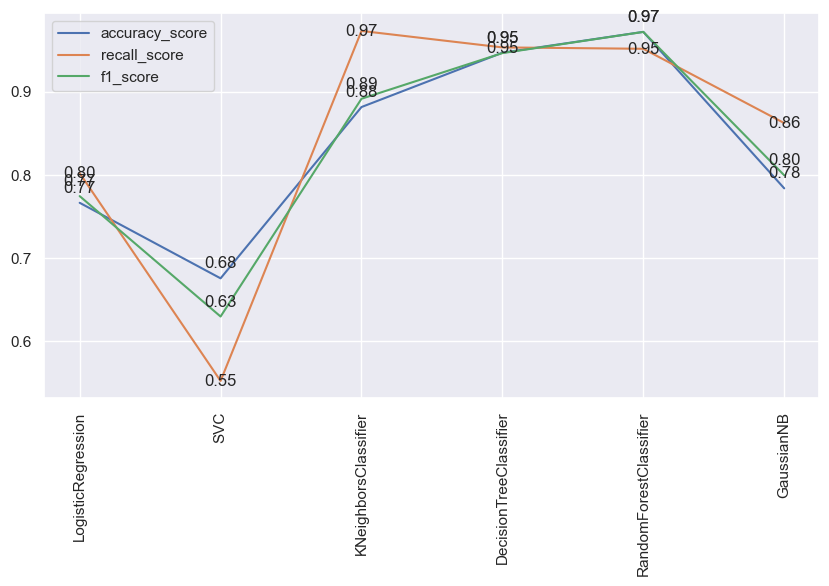

In [24]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Features and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Generating Column Transformer
categorical = df.select_dtypes("object").columns
column_transformer = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical)],
                                        remainder="passthrough")
# Generating First Preprocessor
preprocessor = Pipeline(steps=[("transformer", column_transformer),
                               ("imputer", SimpleImputer(strategy="median"))])
# Preprocessing Features
X = preprocessor.fit_transform(X)
# Oversampling Data with SMOTE
X, y = SMOTE(sampling_strategy="minority").fit_resample(X, y)
# Calculating Cross Validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Finding Best Model
models = [LogisticRegression(), SVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]
names, accuracy_scores, recall_scores, f1_scores = list(), list(), list(), list()
for model in models:
    names.append(model.__class__.__name__)
    # Calculating Accuracy Score
    accuracy = mean(cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1))
    accuracy_scores.append(accuracy)
    # Calculating Recall Score
    recall= mean(cross_val_score(model, X, y, scoring="recall", cv=cv, n_jobs=-1))
    recall_scores.append(recall)
    # Calculating F1 Score
    f1 = mean(cross_val_score(model, X, y, scoring="f1", cv=cv, n_jobs=-1))
    f1_scores.append(f1)
plt.figure(figsize=[10, 5])
plt.plot(names, accuracy_scores, label="accuracy_score")
plt.plot(names, recall_scores, label="recall_score")
plt.plot(names, f1_scores, label="f1_score")
plt.xticks(rotation=90)
plt.legend(loc="best")
for name, accuracy, recall, f1 in zip(names, accuracy_scores, recall_scores, f1_scores):
    plt.annotate(f"{accuracy:.2f}", xy=(name, accuracy), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    plt.annotate(f"{recall:.2f}", xy=(name, recall), xytext=(0, 5), textcoords="offset points", ha='center', va='top')
    plt.annotate(f"{f1:.2f}", xy=(name, f1), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
plt.show()

Looks like data leakage caused overfitting. Let's use train test split in order to prevent data leakage.

c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


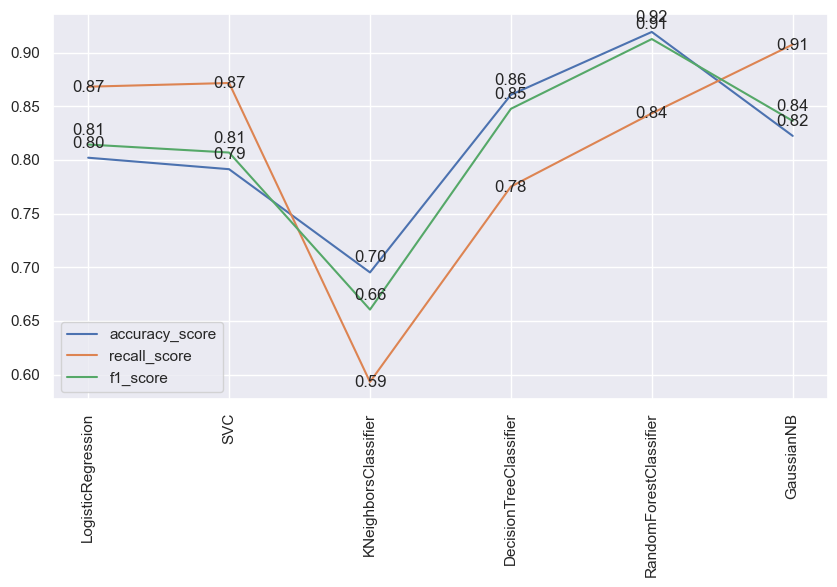

In [13]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Features and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# Generating Column Transformer
categorical = df.select_dtypes("object").columns
column_transformer = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical)],
                                        remainder="passthrough")
# Generating First Preprocessor
preprocessor = Pipeline(steps=[("transformer", column_transformer),
                               ("imputer", SimpleImputer(strategy="median"))])
# Preprocessing Features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
# Oversampling Data with SMOTE
X_train, y_train = SMOTE(sampling_strategy="minority").fit_resample(X_train, y_train)
X_test, y_test = SMOTE(sampling_strategy="minority").fit_resample(X_test, y_test)
# Comparing Different Models
models = [LogisticRegression(), SVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]
names, accuracy_scores, recall_scores, f1_scores = list(), list(), list(), list()
for model in models:
    names.append(model.__class__.__name__)
    # Fitting Model
    model.fit(X_train, y_train)
    # Predicting with Model
    y_prediction = model.predict(X_test)
    # Calculating Accuracy Score
    accuracy = accuracy_score(y_test, y_prediction)
    accuracy_scores.append(accuracy)
    # Calculating Recall Score
    recall= recall_score(y_test, y_prediction)
    recall_scores.append(recall)
    # Calculating F1 Score
    f1 = f1_score(y_test, y_prediction)
    f1_scores.append(f1)
plt.figure(figsize=[10, 5])
plt.plot(names, accuracy_scores, label="accuracy_score")
plt.plot(names, recall_scores, label="recall_score")
plt.plot(names, f1_scores, label="f1_score")
plt.xticks(rotation=90)
plt.legend(loc="best")
for name, accuracy, recall, f1 in zip(names, accuracy_scores, recall_scores, f1_scores):
    plt.annotate(f"{accuracy:.2f}", xy=(name, accuracy), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    plt.annotate(f"{recall:.2f}", xy=(name, recall), xytext=(0, 5), textcoords="offset points", ha='center', va='top')
    plt.annotate(f"{f1:.2f}", xy=(name, f1), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
plt.show()

Based on above results, RandomForestClassifier has obtained the best scores. So we're going to HyperTune it in our next steps.

Accuracy: 92.00%
Recall: 84.69%
F1: 91.37%


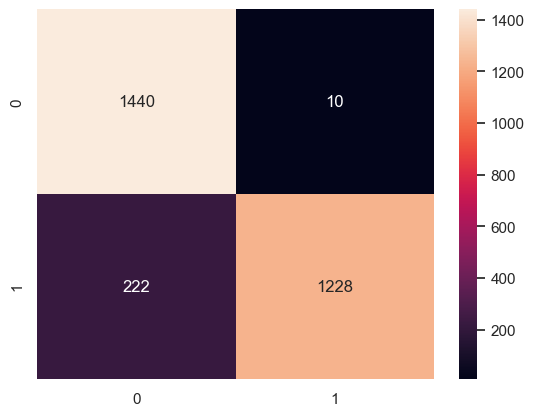

In [15]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Features and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# Generating Column Transformer
categorical = df.select_dtypes("object").columns
column_transformer = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical)],
                                        remainder="passthrough")
# Generating First Preprocessor
preprocessor = Pipeline(steps=[("transformer", column_transformer),
                               ("imputer", SimpleImputer(strategy="median"))])
# Preprocessing Features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
# Oversampling Data with SMOTE
X_train, y_train = SMOTE(sampling_strategy="minority").fit_resample(X_train, y_train)
X_test, y_test = SMOTE(sampling_strategy="minority").fit_resample(X_test, y_test)
# Modeling with RandomForestClassifier
model = RandomForestClassifier()
# Fitting Model
model.fit(X_train, y_train)
# Predicting with Model
y_prediction = model.predict(X_test)
# Calculating Accuracy Score
accuracy = accuracy_score(y_test, y_prediction)
print(f"Accuracy: {accuracy:.2%}")
# Calculating Recall Score
recall= recall_score(y_test, y_prediction)
print(f"Recall: {recall:.2%}")
# Calculating F1 Score
f1 = f1_score(y_test, y_prediction)
print(f"F1: {f1:.2%}")
# Calculating Accuracy Score
matrix = confusion_matrix(y_test, y_prediction)
sns.heatmap(matrix, annot=True, fmt="d")
plt.show()

# 5. Evaluation

c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\PQ\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322

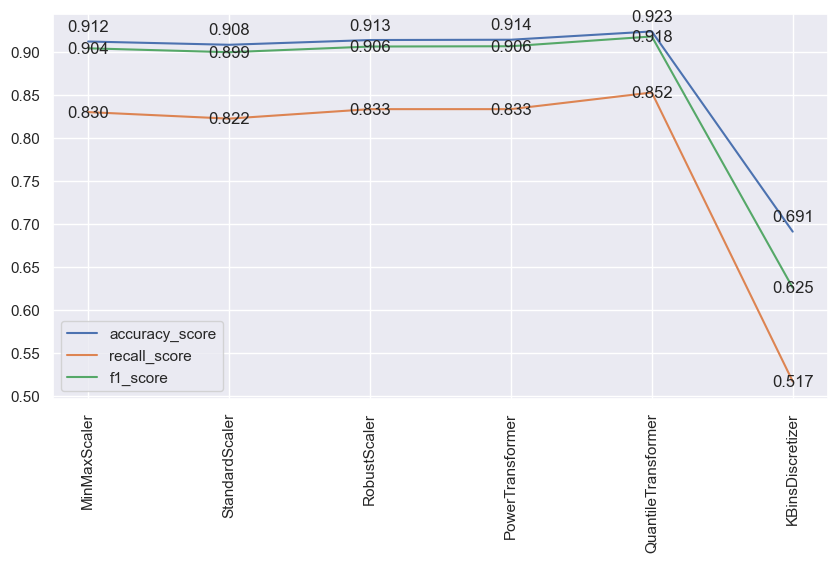

In [18]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Features and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# Generating Column Transformer
categorical = df.select_dtypes("object").columns
column_transformer = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical)],
                                        remainder="passthrough")
# Generating First Preprocessor
preprocessor = Pipeline(steps=[("transformer", column_transformer),
                               ("imputer", SimpleImputer(strategy="median"))])
# Preprocessing Features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
# Oversampling Data with SMOTE
X_train, y_train = SMOTE(sampling_strategy="minority").fit_resample(X_train, y_train)
X_test, y_test = SMOTE(sampling_strategy="minority").fit_resample(X_test, y_test)
# Modeling with RandomForestClassifier
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler(), PowerTransformer(), QuantileTransformer(output_distribution="normal"), KBinsDiscretizer()]
names, accuracy_scores, recall_scores, f1_scores = list(), list(), list(), list()
for scaler in scalers:
    names.append(scaler.__class__.__name__)
    pipeline = Pipeline(steps=[("transformer", scaler),
                               ("model", RandomForestClassifier())])
    # Fitting Pipeline
    pipeline.fit(X_train, y_train)
    # Predicting with Model
    y_prediction = pipeline.predict(X_test)
    # Calculating Accuracy Score
    accuracy = accuracy_score(y_test, y_prediction)
    accuracy_scores.append(accuracy)
    # Calculating Recall Score
    recall = recall_score(y_test, y_prediction)
    recall_scores.append(recall)
    # Calculating F1 Score
    f1 = f1_score(y_test, y_prediction)
    f1_scores.append(f1)
# Comparing Scores with Different Scalers
plt.figure(figsize=[10, 5])
plt.plot(names, accuracy_scores, label="accuracy_score")
plt.plot(names, recall_scores, label="recall_score")
plt.plot(names, f1_scores, label="f1_score")
plt.xticks(rotation=90)
plt.legend(loc="best")
for name, accuracy, recall, f1 in zip(names, accuracy_scores, recall_scores, f1_scores):
    plt.annotate(f"{accuracy:.3f}", xy=(name, accuracy), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    plt.annotate(f"{recall:.3f}", xy=(name, recall), xytext=(0, 5), textcoords="offset points", ha='center', va='top')
    plt.annotate(f"{f1:.3f}", xy=(name, f1), xytext=(0, 5), textcoords="offset points", ha='center', va='top')
plt.show()

Looks like quantile transformer has the best performance. Let's use it in our pipeline.

### Feature Importance

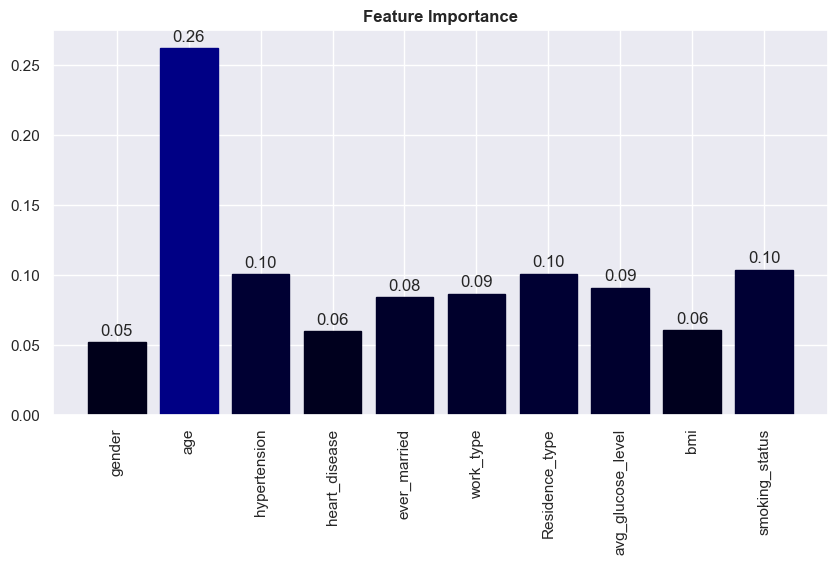

In [24]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Features and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Generating First Preprocessor
preprocessor = Pipeline(steps=[("encoder", OrdinalEncoder()),
                               ("imputer", SimpleImputer(strategy="median"))])
# Preprocessing Features
X = preprocessor.fit_transform(X)
# Oversampling Data with SMOTE
X, y = SMOTE(sampling_strategy="minority").fit_resample(X, y)
# Modeling with RandomForestClassifier
model = RandomForestClassifier()
# Fitting Model
model.fit(X, y)
# Calculating Importances
importances = model.feature_importances_
plt.figure(figsize=(10, 5))
bars = plt.bar(x=df.columns[:-1], height=importances)
plt.title("Feature Importance", fontweight="bold")
plt.xticks(rotation=90)
for bar in bars:
    height = bar.get_height()
    bar.set_color(f"#0000{int((abs(height) / 0.5) * 255):02X}")
    plt.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.show()

### Model HyperTuning

In [26]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Features and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# Generating Column Transformer
categorical = df.select_dtypes("object").columns
column_transformer = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical)],
                                        remainder="passthrough")
# Generating First Preprocessor
preprocessor = Pipeline(steps=[("transformer", column_transformer),
                               ("imputer", SimpleImputer(strategy="median"))])
# Preprocessing Features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
# Oversampling Data with SMOTE
X_train, y_train = SMOTE(sampling_strategy="minority").fit_resample(X_train, y_train)
X_test, y_test = SMOTE(sampling_strategy="minority").fit_resample(X_test, y_test)
# Generating Pipeline with RandomForestClassifier
# pipeline = Pipeline(steps=[("quantile_transformer", QuantileTransformer(output_distribution="normal")),
#                            ("feature_selection", SelectKBest(score_func=f_classif)),
#                            ("feature_engineering", PolynomialFeatures()),
#                            ("model", RandomForestClassifier())])
# Defining Param Grid
# param_grid = {
#     "quantile_transformer__n_quantiles": [500, 1000, 1500],
#     "feature_selection__k": [i + 1 for i in range(X.shape[1])],
#     "feature_engineering__degree": [1, 2, 3],
#     "feature_engineering__include_bias": [True, False],
#     "model__n_estimators": [50, 100, 150, 200],
#     "model__criterion": ["gini", "entropy", "log_loss"],
#     "model__max_features": ["sqrt", "log2"]
# }
# Generating RandomForestClassifier Model
model = RandomForestClassifier()
# Defining Param Grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2"]
}
# Searching for Best HyperParameters
search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
# Fitting the Best Model
result = search.fit(X_train, y_train)
# Results for Best Model
print(f"Best Parameters: {result.best_params_}")
best_model = result.best_estimator_
y_prediction = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_prediction)
print(f"Best Accuracy: {best_accuracy:.2%}")

Best Parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}
Best Accuracy: 91.45%


### Modeling the Dataset with Best Model

Accuracy: 95.07%
Recall: 90.41%
F1: 94.83%
ROC_AUC: 95.07%


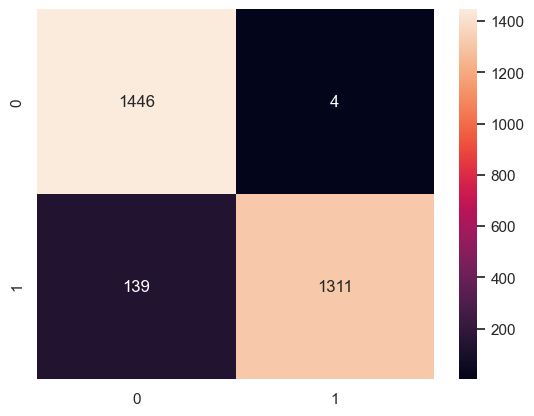

In [53]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Features and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# Generating Column Transformer
categorical = df.select_dtypes("object").columns
column_transformer = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical)],
                                       remainder="passthrough")
# Generating First Preprocessor
preprocessor = Pipeline(steps=[("transformer", column_transformer),
                               ("imputer", SimpleImputer(strategy="median"))])
# Preprocessing Features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
# Oversampling Data with SMOTE
X_train, y_train = SMOTE(sampling_strategy="minority").fit_resample(X_train, y_train)
X_test, y_test = SMOTE(sampling_strategy="minority").fit_resample(X_test, y_test)
# Generating Pipeline
pipeline = Pipeline(steps=[("quantile_transformer", QuantileTransformer(output_distribution="normal")),
                           ("feature_engineering", PolynomialFeatures(degree=2, include_bias=True)),
                           ("model", RandomForestClassifier(n_estimators=200))])
# Fitting Pipeline
pipeline.fit(X_train, y_train)
# Predicting with Pipeline
y_prediction = pipeline.predict(X_test)
# Calculating Accuracy Score
accuracy = accuracy_score(y_test, y_prediction)
print(f"Accuracy: {accuracy:.2%}")
# Calculating Recall Score
recall= recall_score(y_test, y_prediction)
print(f"Recall: {recall:.2%}")
# Calculating F1 Score
f1 = f1_score(y_test, y_prediction)
print(f"F1: {f1:.2%}")
# Calculating ROC_AUC Score
roc_auc = roc_auc_score(y_test, y_prediction)
print(f"ROC_AUC: {roc_auc:.2%}")
# Calculating Confusion Matrix
matrix = confusion_matrix(y_test, y_prediction)
sns.heatmap(matrix, annot=True, fmt="d")
plt.show()

# 6. Deployment

### Fitting Preprocessor and Pipeline with the Train Section and Saving Them as Pickle Files

In [19]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Features and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=1)
# Generating Column Transformer
categorical = df.select_dtypes("object").columns
column_transformer = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), categorical)],
                                       remainder="passthrough")
# Generating First Preprocessor
preprocessor = Pipeline(steps=[("transformer", column_transformer),
                               ("imputer", SimpleImputer(strategy="median"))])
# Preprocessing Features
X_train = preprocessor.fit_transform(X_train)
# Saving Preprocessor as a Pickle File
dump(preprocessor, open("preprocessor.pkl", mode="wb"))
# Oversampling Data with SMOTE
X_train, y_train = SMOTE(sampling_strategy="minority").fit_resample(X_train, y_train)
# Generating Pipeline
pipeline = Pipeline(steps=[("quantile_transformer", QuantileTransformer(output_distribution="normal")),
                           ("feature_engineering", PolynomialFeatures(degree=2, include_bias=True)),
                           ("model", RandomForestClassifier(criterion="entropy"))])
# Fitting Pipeline with the Train Section
pipeline.fit(X_train, y_train)
# Saving Pipeline as a Pickle File
dump(pipeline, open("pipeline.pkl", mode="wb"))

### Loading Preprocessor and Pipeline and Predicting Test Section with Them

Accuracy: 95.07%
Recall: 90.48%
F1: 94.83%
ROC_AUC: 95.07%


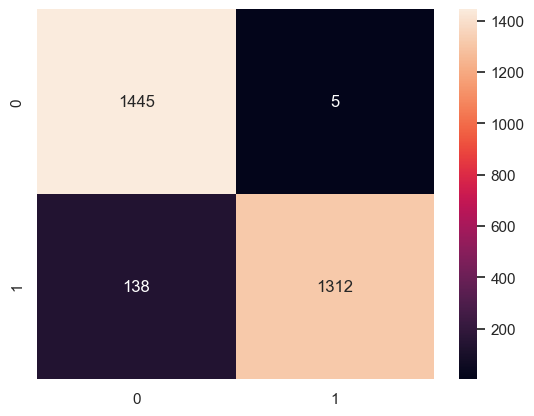

In [23]:
# Loading Dataset
df = read_csv("healthcare-dataset-stroke-data.csv", na_values="N/A")
# Setting Index Values
df.index = range(1, df.shape[0] + 1)
# Removing Ineffective Column
df.drop("id", axis=1, inplace=True)
# Drop Sample with "Other" gender
df.drop(df[df["gender"] == "Other"].index, axis=0, inplace=True)
# Splitting Data into Features and Target
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
# Splitting Data into Train and Test Sections
_, X_test, _, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# Loading Preprocessor
preprocessor = load(open("preprocessor.pkl", mode="rb"))
# Preprocessing Features
X_test = preprocessor.transform(X_test)
# Oversampling Data with SMOTE
X_test, y_test = SMOTE(sampling_strategy="minority").fit_resample(X_test, y_test)
# Loading Pipeline
pipeline = load(open("pipeline.pkl", mode="rb"))
# Fitting Pipeline with the Train Section
y_prediction = pipeline.predict(X_test)
# Calculating Accuracy Score
accuracy = accuracy_score(y_test, y_prediction)
print(f"Accuracy: {accuracy:.2%}")
# Calculating Recall Score
recall= recall_score(y_test, y_prediction)
print(f"Recall: {recall:.2%}")
# Calculating F1 Score
f1 = f1_score(y_test, y_prediction)
print(f"F1: {f1:.2%}")
# Calculating ROC_AUC Score
roc_auc = roc_auc_score(y_test, y_prediction)
print(f"ROC_AUC: {roc_auc:.2%}")
# Calculating Confusion Matrix
matrix = confusion_matrix(y_test, y_prediction)
sns.heatmap(matrix, annot=True, fmt="d")
plt.show()

### Predicting with Model

In [153]:
# Inputting Gender
wrong_gender = True
while wrong_gender:
    gender = input("Please enter your gender: ( Male / Female ) ").capitalize()
    if gender in ["Male", "Female"]:
        wrong_gender = False
# Inputting Age
wrong_age = True
while wrong_age:
    try:
        age = float(input("Please enter your age: "))
        if age >= 1:
            wrong_age = False
    except ValueError:
        pass
# Inputting Hypertension
wrong_hypertension = True
while wrong_hypertension:
    hypertension = input("Do you have hypertension? ( Yes / No ) ").capitalize()
    if hypertension in ["Yes", "No"]:
        wrong_hypertension = False
        hypertension = 1 if hypertension == "Yes" else 0
# Inputting Heart Disease
wrong_heart_disease = True
while wrong_heart_disease:
    heart_disease = input("Do you have heart disease? ( Yes / No ): ").capitalize()
    if heart_disease in ["Yes", "No"]:
        wrong_heart_disease = False
        heart_disease = 1 if heart_disease == "Yes" else 0
# Inputting Marital Status
wrong_ever_married = True
while wrong_ever_married:
    ever_married = input("Have you ever married? ( Yes / No ): ").capitalize()
    if ever_married in ["Yes", "No"]:
        wrong_ever_married = False
# Inputting Work Type
wrong_work_type = True
while wrong_work_type:
    work_type = input("What is your work type? ( Private / Self-employed / Govt_job / children / Never_worked ): ")
    if work_type.capitalize() in ['Private', 'Self-employed', 'Govt_job', 'Never_worked']:
        work_type = work_type.capitalize()
        wrong_work_type = False
    elif work_type.lower() == "children":
        work_type = work_type.lower()
        wrong_work_type = False
# Inputting Residence Type
wrong_residence_type = True
while wrong_residence_type:
    residence_type = input("What is your residence type? ( Urban / Rural ): ").capitalize()
    if residence_type in ["Urban", "Rural"]:
        wrong_residence_type = False
# Inputting Average Glucose Level
wrong_avg_glucose_level = True
while wrong_avg_glucose_level:
    try:
        avg_glucose_level = float(input("How much is your average glucose level: "))
        if avg_glucose_level >= 50:
            wrong_avg_glucose_level = False
    except ValueError:
        pass
# Inputting BMI
wrong_bmi = True
while wrong_bmi:
    try:
        bmi = float(input("How much is your body mass index: "))
        if bmi >= 10:
            wrong_bmi = False
    except ValueError:
        bmi = nan
        wrong_bmi = False
# Inputting Work Type
wrong_smoking_status= True
while wrong_smoking_status:
    smoking_status= input("What is your smoking status? ( formerly smoked / never smoked / smokes / Unknown ): ")
    if smoking_status.lower() in ['formerly smoked', 'never smoked', 'smokes']:
        smoking_status = smoking_status.lower()
        wrong_smoking_status = False
    elif smoking_status.capitalize() == "Unknown":
        smoking_status = smoking_status.capitalize()
        wrong_smoking_status = False
# Generating Features Data Frame
features_df = DataFrame({
    "gender": [gender],
    "age": [age],
    "hypertension": [hypertension],
    "heart_disease": [heart_disease],
    "ever_married": [ever_married],
    "work_type": [work_type],
    "Residence_type": [residence_type],
    "avg_glucose_level": [avg_glucose_level],
    "bmi": [bmi],
    "smoking_status": [smoking_status]
})
# Loading Preprocessor
preprocessor = load(open("preprocessor.pkl", mode="rb"))
# Transforming Features with Preprocessor
features_df_t = preprocessor.transform(features_df)
# Loading Pipeline
pipeline = load(open("pipeline.pkl", mode="rb"))
# Predicting with Pipeline
result = pipeline.predict(features_df_t)
features_df["stroke"] = result
probability = pipeline.predict_proba(features_df_t)
print(f"\nStroke Probability: {probability[0, 1]:.0%}")
features_df


Stroke Probability: 71%


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,63.0,0,0,Yes,Private,Urban,91.0,NaN,formerly smoked,1


### Designing a GUI App to Predict Stroke Probability

In [2]:
#Jumping to the Next Field with Enter
def jump_to_next_entry(event):
    event.widget.tk_focusNext().focus()
#Jumping to the Previous Field with Shift + Enter
def jump_to_previous_entry(event):
    event.widget.tk_focusPrev().focus()
# Check Button Function
def check_form():
    errors = []
    # Checking Gender Limitations
    if gender.get() == "Not defined":
        errors.append("- Please define your gender.")
        label_gender.config(background="#ffc0cb")
    else:
        label_gender.config(background="#caf4fe")
    # Checking Age Limitations
    if not text_age.get():
        errors.append("- Please enter your age.")
        text_age.config(background="#ffc0cb")
    elif not text_age.get().replace("-", "", 1).replace(".", "", 1).isnumeric():
        errors.append("- Age must be a float.")
        text_age.config(background="#ffc0cb")
    elif text_age.get().startswith("-"):
        errors.append("- Age can't be a negative number.")
        text_age.config(background="#ffc0cb")
    elif text_age.get().count("-") == 1:
        errors.append("- Age must be a float.")
        text_age.config(background="#ffc0cb")
    elif float(text_age.get()) < 1:
        errors.append("- Age can't be less than 1 year.")
        text_age.config(background="#ffc0cb")
    else:
        text_age.config(background="white")
    # Checking Hypertension Limitations
    if hypertension.get() == -1:
        errors.append("- Please define your hypertension status.")
        label_hypertension.config(background="#ffc0cb")
    else:
        label_hypertension.config(background="#caf4fe")
    # Checking Heart Disease Limitations
    if heart_disease.get() == -1:
        errors.append("- Please define your heart disease status.")
        label_heart_disease.config(background="#ffc0cb")
    else:
        label_heart_disease.config(background="#caf4fe")
    # Checking BMI Limitations
    if not text_bmi.get():
        pass
    elif not text_bmi.get().replace("-", "", 1).replace(".", "", 1).isnumeric():
        errors.append("- BMI must be a float.")
        text_bmi.config(background="#ffc0cb")
    elif text_bmi.get().startswith("-"):
        errors.append("- BMI can't be a negative number.")
        text_bmi.config(background="#ffc0cb")
    elif text_bmi.get().count("-") == 1:
        errors.append("- BMI must be a float.")
        text_bmi.config(background="#ffc0cb")
    elif float(text_bmi.get()) < 10:
        errors.append("- BMI can't be less than 10.")
        text_bmi.config(background="#ffc0cb")
    else:
        text_bmi.config(background="white")
    # Checking Marital Status Limitations
    if ever_married.get() == "Not defined":
        errors.append("- Please define your marital status.")
        label_ever_married.config(background="#ffc0cb")
    else:
        label_ever_married.config(background="#caf4fe")
    # Checking Average Glucose Level Limitations
    if not text_avg_glucose_level.get():
        errors.append("- Please enter your average glucose level.")
        text_avg_glucose_level.config(background="#ffc0cb")
    elif not text_avg_glucose_level.get().replace("-", "", 1).replace(".", "", 1).isnumeric():
        errors.append("- Average glucose level must be a float.")
        text_avg_glucose_level.config(background="#ffc0cb")
    elif text_avg_glucose_level.get().startswith("-"):
        errors.append("- Average glucose level can't be a negative number.")
        text_avg_glucose_level.config(background="#ffc0cb")
    elif text_avg_glucose_level.get().count("-") == 1:
        errors.append("- Average glucose level must be a float.")
        text_avg_glucose_level.config(background="#ffc0cb")
    elif float(text_avg_glucose_level.get()) < 50:
        errors.append("- Average glucose level can't be less than 50.")
        text_avg_glucose_level.config(background="#ffc0cb")
    else:
        text_avg_glucose_level.config(background="white")
    # Checking Residence Type Limitations
    if residence_type.get() == "Not defined":
        errors.append("- Please define your residence type.")
        label_residence_type.config(background="#ffc0cb")
    else:
        label_residence_type.config(background="#caf4fe")
    # Checking Work Type Limitations
    if dropdown_work_type.get() not in dropdown_work_type["values"]:
        errors.append("- Please select your work type from the list.")
        style1.configure("TCombobox", fieldbackground="#ffc0cb")
    else:
        style1.configure("TCombobox", fieldbackground="white")
    # Checking Smoking Status Limitations
    if dropdown_smoking_status.get() not in dropdown_smoking_status["values"]:
        errors.append("- Please select your smoking status from the list.")
        style2.configure("TCombobox", fieldbackground="#ffc0cb")
    else:
        style2.configure("TCombobox", fieldbackground="white")
    # Checking Errors Status and Showing Errors via Message Box
    if len(errors):
        errors.insert(0, "Please correct below items to proceed:\n")
        error_message = "\n".join(errors)
        messagebox.showerror("Error",error_message)
    else:
        # Generating Features Data Frame
        features_df = DataFrame({
            "gender": [gender.get()],
            "age": [int(text_age.get())],
            "hypertension": [hypertension.get()],
            "heart_disease": [heart_disease.get()],
            "ever_married": [ever_married.get()],
            "work_type": [dropdown_work_type.get()],
            "Residence_type": [residence_type.get()],
            "avg_glucose_level": [float(text_avg_glucose_level.get())],
            "bmi": [None],
            "smoking_status": [dropdown_smoking_status.get()]
        })
        # Assigning BMI Value
        try:
            features_df["bmi"] = float(text_bmi.get())
        except ValueError:
            features_df["bmi"] = nan
        # Transforming Features with Preprocessor
        features_df_t = preprocessor.transform(features_df)
        # Predicting with Pipeline
        result = pipeline.predict(features_df_t)[0]
        probability = pipeline.predict_proba(features_df_t)[0, 1]
        # Showing the Result
        if result:
            messagebox.showwarning("Warning", f"Be Careful.\n\nYou are at risk of stroke.\n\nYour stroke probability is {probability:.0%}")
            clear_form()
        else:
            messagebox.showinfo("Congrats", f"Congratulations.\n\nYou are not at risk of stroke.\n\nYour stroke probability is {probability:.0%}")
            clear_form()
# Clear Button Function
def clear_form():
    label_gender.config(background="#caf4fe")
    gender.set("Not defined")
    text_age.delete(0,tk.END)
    text_age.config(background="white")
    label_hypertension.config(background="#caf4fe")
    hypertension.set(-1)
    label_heart_disease.config(background="#caf4fe")
    heart_disease.set(-1)
    text_bmi.delete(0,tk.END)
    text_bmi.config(background="white")
    label_ever_married.config(background="#caf4fe")
    ever_married.set("Not defined")
    text_avg_glucose_level.delete(0,tk.END)
    text_avg_glucose_level.config(background="white")
    label_residence_type.config(background="#caf4fe")
    residence_type.set("Not defined")
    dropdown_work_type.set("")
    style1.configure("TCombobox", fieldbackground="white")
    dropdown_smoking_status.set("")
    style2.configure("TCombobox", fieldbackground="white")
    gender1.focus()
# Quit Button Function
def quit_form():
    form.destroy()
# Loading Preprocessor and Pipeline
preprocessor = load(open("preprocessor.pkl", mode="rb"))
pipeline = load(open("pipeline.pkl", mode="rb"))
# Creating Form Window
form = tk.Tk()
screen_height = form.winfo_screenheight()
screen_width = form.winfo_screenwidth()
form.title("Stroke Probability Prediction")
# Defining Taskbar Icon
taskbar_icon = 'mycompany.myproduct.subproduct.version'
ctypes.windll.shell32.SetCurrentProcessExplicitAppUserModelID(taskbar_icon)
form.iconbitmap("hospital.ico")
# Adjusting Form Window's Appearance
form.config(background="#caf4fe")
form.attributes("-alpha","0.95")
form.geometry(f"800x400+{(screen_width - 800) // 2}+{(screen_height - 400) // 2}")
form.resizable(False, False)
#Defining Shortcuts for Form Window
form.bind("<Control-s>", lambda event: check_form())
form.bind("<Control-z>", lambda event: clear_form())
form.bind("<Escape>", lambda event: quit_form())
# Designing Gender Buttons
label_gender = tk.Label(form, text="Gender:",background="#caf4fe",foreground="black",font=("Arial",16))
gender = tk.StringVar(value="Not defined")
gender1 = tk.Radiobutton(form, text="Male", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=gender, value="Male")
gender1.bind("<Return>",jump_to_next_entry)
gender1.bind("<Shift-Return>",jump_to_previous_entry)
gender2 = tk.Radiobutton(form, text="Female", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=gender, value="Female")
gender2.bind("<Return>",jump_to_next_entry)
gender2.bind("<Shift-Return>",jump_to_previous_entry)
label_gender.grid(row=0, column=0, rowspan=2, sticky="w")
gender1.grid(row=0, column=1, sticky="w")
gender2.grid(row=1, column=1, sticky="w")
# Designing Age Entry
label_age = tk.Label(form, text="Age:",background="#caf4fe",foreground="black",font=("Arial",16))
text_age = tk.Entry(form, width=10, font=("Arial",16))
text_age.bind("<Return>",jump_to_next_entry)
text_age.bind("<Shift-Return>",jump_to_previous_entry)
label_age.grid(row=0, column=2, rowspan=2, ipadx=20, sticky="e")
text_age.grid(row=0, column=3, rowspan=2, sticky="w")
# Designing Hypertension Buttons
label_hypertension = tk.Label(form, text="Hypertension:",background="#caf4fe",foreground="black",font=("Arial",16))
hypertension = tk.IntVar(value=-1)
hypertension1 = tk.Radiobutton(form, text="Yes", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=hypertension, value=1)
hypertension1.bind("<Return>",jump_to_next_entry)
hypertension1.bind("<Shift-Return>",jump_to_previous_entry)
hypertension2 = tk.Radiobutton(form, text="No", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=hypertension, value=0)
hypertension2.bind("<Return>",jump_to_next_entry)
hypertension2.bind("<Shift-Return>",jump_to_previous_entry)
label_hypertension.grid(row=0, column=4, rowspan=2, sticky="e", ipadx=30)
hypertension1.grid(row=0, column=5, sticky="w")
hypertension2.grid(row=1, column=5, sticky="w")
# Occupy Free Space
occupier1 = tk.Label(form, background="#caf4fe")
occupier1.grid(row=2, column=0, columnspan=5)
# Designing Heart Disease Buttons
label_heart_disease = tk.Label(form, text="Heart Disease:",background="#caf4fe",foreground="black",font=("Arial",16))
heart_disease = tk.IntVar(value=-1)
heart_disease1 = tk.Radiobutton(form, text="Yes", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=heart_disease, value=1)
heart_disease1.bind("<Return>",jump_to_next_entry)
heart_disease1.bind("<Shift-Return>",jump_to_previous_entry)
heart_disease2 = tk.Radiobutton(form, text="No", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=heart_disease, value=0)
heart_disease2.bind("<Return>",jump_to_next_entry)
heart_disease2.bind("<Shift-Return>",jump_to_previous_entry)
label_heart_disease.grid(row=3, column=0, rowspan=2, sticky="w")
heart_disease1.grid(row=3, column=1, sticky="w")
heart_disease2.grid(row=4, column=1, sticky="w")
# Designing BMI Entry
label_bmi = tk.Label(form, text="BMI:",background="#caf4fe",foreground="black",font=("Arial",16))
text_bmi = tk.Entry(form, width=10, font=("Arial",16))
text_bmi.bind("<Return>",jump_to_next_entry)
text_bmi.bind("<Shift-Return>",jump_to_previous_entry)
label_bmi.grid(row=3, column=2, rowspan=2, ipadx=20, sticky="e")
text_bmi.grid(row=3, column=3, rowspan=2, sticky="w")
# Designing Marital Status Buttons
label_ever_married = tk.Label(form, text="Ever Married:",background="#caf4fe",foreground="black",font=("Arial",16))
ever_married = tk.StringVar(value="Not defined")
ever_married1 = tk.Radiobutton(form, text="Yes", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=ever_married, value="Yes")
ever_married1.bind("<Return>",jump_to_next_entry)
ever_married1.bind("<Shift-Return>",jump_to_previous_entry)
ever_married2 = tk.Radiobutton(form, text="No", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=ever_married, value="No")
ever_married2.bind("<Return>",jump_to_next_entry)
ever_married2.bind("<Shift-Return>",jump_to_previous_entry)
label_ever_married.grid(row=3, column=4, rowspan=2, sticky="e", ipadx=30)
ever_married1.grid(row=3, column=5, sticky="w")
ever_married2.grid(row=4, column=5, sticky="w")
# Occupy Free Space
occupier2 = tk.Label(form, background="#caf4fe")
occupier2.grid(row=5, column=0, columnspan=5)
# Designing Average Glucose Level Entry
label_avg_glucose_level = tk.Label(form, text="Average Glucose Level:",background="#caf4fe",foreground="black",font=("Arial",16))
text_avg_glucose_level = tk.Entry(form, width=10, font=("Arial",16))
text_avg_glucose_level.bind("<Return>",jump_to_next_entry)
text_avg_glucose_level.bind("<Shift-Return>",jump_to_previous_entry)
label_avg_glucose_level.grid(row=6, column=0, rowspan=2, columnspan=2, sticky="w")
text_avg_glucose_level.grid(row=6, column=2, rowspan=2, columnspan=2, sticky="w")
# Designing Residence Type Buttons
label_residence_type = tk.Label(form, text="Residence Type:",background="#caf4fe",foreground="black",font=("Arial",16))
residence_type = tk.StringVar(value="Not defined")
residence_type1 = tk.Radiobutton(form, text="Urban", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=residence_type, value="Urban")
residence_type1.bind("<Return>",jump_to_next_entry)
residence_type1.bind("<Shift-Return>",jump_to_previous_entry)
residence_type2 = tk.Radiobutton(form, text="Rural", background="#caf4fe", foreground="black", font=("Arial",14,"bold"), variable=residence_type, value="Rural")
residence_type2.bind("<Return>",jump_to_next_entry)
residence_type2.bind("<Shift-Return>",jump_to_previous_entry)
label_residence_type.grid(row=6, column=3, rowspan=2, columnspan=2, sticky="e", ipadx=30)
residence_type1.grid(row=6, column=5, sticky="w")
residence_type2.grid(row=7, column=5, sticky="w")
# Occupy Free Space
occupier3 = tk.Label(form, background="#caf4fe")
occupier3.grid(row=8, column=0, columnspan=5)
# Designing Work Type Drop Down List
label_work_type = tk.Label(form, text="Work Type:",background="#caf4fe",foreground="black",font=("Arial",16))
dropdown_work_type = ttk.Combobox(width=14, values=['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'], font=("Arial",14))
dropdown_work_type.bind("<Return>",jump_to_next_entry)
dropdown_work_type.bind("<Shift-Return>",jump_to_previous_entry)
style1 = ttk.Style()
style1.theme_use("clam")
label_work_type.grid(row=9, column=0, rowspan=2, sticky="w")
dropdown_work_type.grid(row=9, column=1, rowspan=2, columnspan=2, sticky="w")
# Designing Smoking Status Drop Down List
label_smoking_status = tk.Label(form, text="Smoking Status:",background="#caf4fe",foreground="black",font=("Arial",16))
dropdown_smoking_status = ttk.Combobox(width=14, values=['formerly smoked', 'never smoked', 'smokes', 'Unknown'], font=("Arial",14))
dropdown_smoking_status.bind("<Return>",jump_to_next_entry)
dropdown_smoking_status.bind("<Shift-Return>",jump_to_previous_entry)
style2 = ttk.Style()
style2.theme_use("clam")
label_smoking_status.grid(row=9, column=3, rowspan=2, sticky="w", ipadx=5)
dropdown_smoking_status.grid(row=9, column=4, rowspan=2, columnspan=2, sticky="w")
# Occupy Free Space
occupier4 = tk.Label(form, background="#caf4fe")
occupier4.grid(row=11, column=0, columnspan=5)
# Designing Check Button
check_button = tk.Button(form, text="Check", font=("Arial",14), padx=20, activebackground="green", activeforeground="white", command=check_form)
check_button.bind("<Return>",jump_to_next_entry)
check_button.bind("<Shift-Return>",jump_to_previous_entry)
check_button.bind("<Enter>",lambda event: check_button.config(background="#00c04b", foreground="white"))
check_button.bind("<Leave>",lambda event: check_button.config(background="SystemButtonFace", foreground="black"))
check_button.grid(row=12, column=0, columnspan=2, pady=15)
# Designing Clear Button
clear_button = tk.Button(form, text="Clear", font=("Arial",14), padx=20, activebackground="green", activeforeground="white", command=clear_form)
clear_button.bind("<Return>",jump_to_next_entry)
clear_button.bind("<Shift-Return>",jump_to_previous_entry)
clear_button.bind("<Enter>",lambda event: clear_button.config(background="#33abf9", foreground="white"))
clear_button.bind("<Leave>",lambda event: clear_button.config(background="SystemButtonFace", foreground="black"))
clear_button.grid(row=12, column=2, columnspan=2, pady=15)
# Designing Quit Button
quit_button = tk.Button(form, text="Quit", font=("Arial",14), padx=20, activebackground="green", activeforeground="white", command=quit_form)
quit_button.bind("<Return>",jump_to_next_entry)
quit_button.bind("<Shift-Return>",jump_to_previous_entry)
quit_button.bind("<Enter>",lambda event: quit_button.config(background="#ff7f7f", foreground="white"))
quit_button.bind("<Leave>",lambda event: quit_button.config(background="SystemButtonFace", foreground="black"))
quit_button.grid(row=12, column=4, columnspan=2, pady=15)
# Assigning Focus to the First Field
gender1.focus()
form.mainloop()